In [1]:
%cd ..
%ls

C:\Users\Dongmin Kim\Documents\OnlineTSAD
 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: 067D-FB3E

 C:\Users\Dongmin Kim\Documents\OnlineTSAD 디렉터리

2023-04-29  오후 03:46    <DIR>          .
2023-04-29  오후 03:46    <DIR>          ..
2023-04-10  오후 01:01               156 .gitignore
2023-05-02  오후 01:47    <DIR>          .idea
2023-04-14  오후 04:53    <DIR>          .ipynb_checkpoints
2023-04-27  오후 09:03    <DIR>          cfgs
2023-05-01  오후 04:33    <DIR>          data
2023-05-01  오후 03:55    <DIR>          EDA
2023-05-01  오후 01:30    <DIR>          Exp
2023-05-02  오후 04:12    <DIR>          figures
2023-04-09  오후 02:54    <DIR>          hptune
2023-04-30  오후 04:38    <DIR>          models
2023-04-26  오후 09:18    <DIR>          outputs
2023-04-22  오후 06:44    <DIR>          plots
2023-04-29  오후 06:53    <DIR>          results
2023-04-29  오후 03:46             3,599 test.py
2023-04-26  오후 08:43    <DIR>          thresholding
2023-03-15  오후 03:49             3,099 train.py
2023-04-22  오후 01:24    <DIR

In [2]:
import numpy as np
import matplotlib as mat
from matplotlib import font_manager, rc

def setPlotStyle():    
    #mat.rcParams['font.family'] = "serif"
    #mat.rcParams['font.serif'] = ["Arial"]
    mat.rcParams['font.family'] = "sans-serif"
    mat.rcParams['font.sans-serif'] = "Times new roman"
    mat.rcParams["axes.titlesize"] = "x-large"
    mat.rcParams['font.size'] = 15
    mat.rcParams['legend.fontsize'] = 15
    mat.rcParams['lines.linewidth'] = 2
    mat.rcParams['lines.color'] = 'r'
    mat.rcParams['axes.grid'] = 1     
    mat.rcParams['axes.xmargin'] = 0.1     
    mat.rcParams['axes.ymargin'] = 0.1     
    mat.rcParams["mathtext.fontset"] = "dejavuserif" #"cm", "stix", etc.
    mat.rcParams['figure.dpi'] = 500
    mat.rcParams['savefig.dpi'] = 500
setPlotStyle()

In [4]:
import torch
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from utils.metrics import get_summary_stats

from models.MLP import MLP

import wandb
import hydra
from omegaconf import DictConfig

from utils.logger import make_logger
from utils.argpass import prepare_arguments, configure_exp_id
from utils.tools import SEED_everything, plot_interval

import warnings
from data.load_data import DataFactory
from Exp.ReconBaselines import *

from easydict import EasyDict as edict
import yaml
import re
import copy

warnings.filterwarnings("ignore")

# load yaml
cfg = {}
loader = yaml.SafeLoader
loader.add_implicit_resolver(
    u'tag:yaml.org,2002:float',
    re.compile(u'''^(?:
     [-+]?(?:[0-9][0-9_]*)\\.[0-9_]*(?:[eE][-+]?[0-9]+)?
    |[-+]?(?:[0-9][0-9_]*)(?:[eE][-+]?[0-9]+)
    |\\.[0-9_]+(?:[eE][-+][0-9]+)?
    |[-+]?[0-9][0-9_]*(?::[0-5]?[0-9])+\\.[0-9_]*
    |[-+]?\\.(?:inf|Inf|INF)
    |\\.(?:nan|NaN|NAN))$''', re.X),
    list(u'-+0123456789.'))

# get cfg
model = "MLP"
with open("cfgs/test_defaults.yaml", "r") as file:
    basic_config = yaml.load(file, Loader=loader)
    cfg.update(basic_config)
with open(f"cfgs/model/{model}.yaml", "r") as file:
    model_config = yaml.load(file, Loader=loader)
    cfg.update({"model": model_config})

In [5]:
cfg['dataset'] = 'SWaT'
cfg["RevIN"] = 'SlowRevIN'
cfg["gamma"] = 0.99
args = prepare_arguments(cfg)
print(args)

logger = make_logger(os.path.join(args.log_path, f'{args.exp_id}.log'))
logger.info(f"Configurations: {args}")

# Data
logger.info(f"Preparing {args.dataset} dataset...")
datafactory = DataFactory(args, logger)
train_dataset, train_loader, test_dataset, test_loader = datafactory()
args.num_channels = train_dataset.X.shape[1]
train_X, train_y, test_X, test_y = train_dataset.X, train_dataset.y, test_dataset.X, test_dataset.y

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[2023-05-02 16:13:57,186] Configurations: {'exp_id': 'MLP_SWaT_normalization_None', 'infer_options': ['offline_all'], 'thresholding': 'None', 'tau_beta': 0.99, 'qStart': 0.9, 'qEnd': 1.0, 'qStep': 0.01, 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 12, 'eval_stride': 12, 'scaler': 'std', 'load_previous_error': True, 'lr': 0.001, 'epochs': 30, 'ttlr': 0.001, 'normalization': 'None', 'gamma': 0.99, 'log_freq': 10, 'checkpoint_path': './checkpoints\\MLP_SWaT_normalization_None', 'log_path': './logs\\MLP_SWaT_normalization_None', 'output_path': './outputs\\MLP_SWaT_normalization_None', 'plot_path': './plots\\MLP_SWaT_normalization_None', 'result_path': './results\\MLP_SWaT_normalization_None', 'plot_anomaly_scores': True, 'plot_recon_status': False, 'defaults': [{'model': 'MLP'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'RevIN': 'SlowRevIN', 'home_dir': '.', 'device': device(type='cpu')}
[2023-05-02 16:13:57,187] Preparing SWaT dataset...
[202

{'exp_id': 'MLP_SWaT_normalization_None', 'infer_options': ['offline_all'], 'thresholding': 'None', 'tau_beta': 0.99, 'qStart': 0.9, 'qEnd': 1.0, 'qStep': 0.01, 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 12, 'eval_stride': 12, 'scaler': 'std', 'load_previous_error': True, 'lr': 0.001, 'epochs': 30, 'ttlr': 0.001, 'normalization': 'None', 'gamma': 0.99, 'log_freq': 10, 'checkpoint_path': './checkpoints\\MLP_SWaT_normalization_None', 'log_path': './logs\\MLP_SWaT_normalization_None', 'output_path': './outputs\\MLP_SWaT_normalization_None', 'plot_path': './plots\\MLP_SWaT_normalization_None', 'result_path': './results\\MLP_SWaT_normalization_None', 'plot_anomaly_scores': True, 'plot_recon_status': False, 'defaults': [{'model': 'MLP'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'RevIN': 'SlowRevIN', 'home_dir': '.', 'device': device(type='cpu')}


[2023-05-02 16:14:07,140] train: X - (496800, 51), y - (496800,) test: X - (449919, 51), y - (449919,)
[2023-05-02 16:14:07,216] Complete.
[2023-05-02 16:14:07,217] Preparing dataloader...
[2023-05-02 16:14:07,726] total train dataset- 647, batch_X - torch.Size([64, 12, 51]), batch_y - torch.Size([64, 12])
[2023-05-02 16:14:07,727] total test dataset- 37493, batch_X - torch.Size([1, 12, 51]), batch_y - torch.Size([1, 12])
[2023-05-02 16:14:07,728] Complete.


(496800, 51) (496800,) (449916, 51) (449916,)


## Visualize

In [6]:
data_df = pd.read_csv("data/SWaT/SWaT_Dataset_Attack_v0.csv", index_col=0)
data_df

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
Timestamp,,,,,,,,,,,,,,,,,,,,,
28/12/2015 10:00:00 AM,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,2,...,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,Normal
28/12/2015 10:00:01 AM,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,2,...,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,Normal
28/12/2015 10:00:02 AM,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,2,...,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1,Normal
28/12/2015 10:00:03 AM,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,2,...,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1,Normal
28/12/2015 10:00:04 AM,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,2,...,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2/1/2016 2:59:55 PM,2.559972,519.5495,2,2,1,168.0979,8.638683,301.9226,2.459488,2,...,2,1,251.1535,0.865024,189.0220,0.000000,1,1,1,Normal
2/1/2016 2:59:56 PM,2.549082,520.4131,2,2,1,168.0979,8.638683,301.9226,2.459488,2,...,2,1,251.0734,0.865024,188.9259,0.000000,1,1,1,Normal
2/1/2016 2:59:57 PM,2.531467,520.6878,2,2,1,168.0979,8.638683,301.9226,2.460129,2,...,2,1,251.0734,0.865024,188.9259,0.000000,1,1,1,Normal


In [6]:
cols = list(data_df.columns)

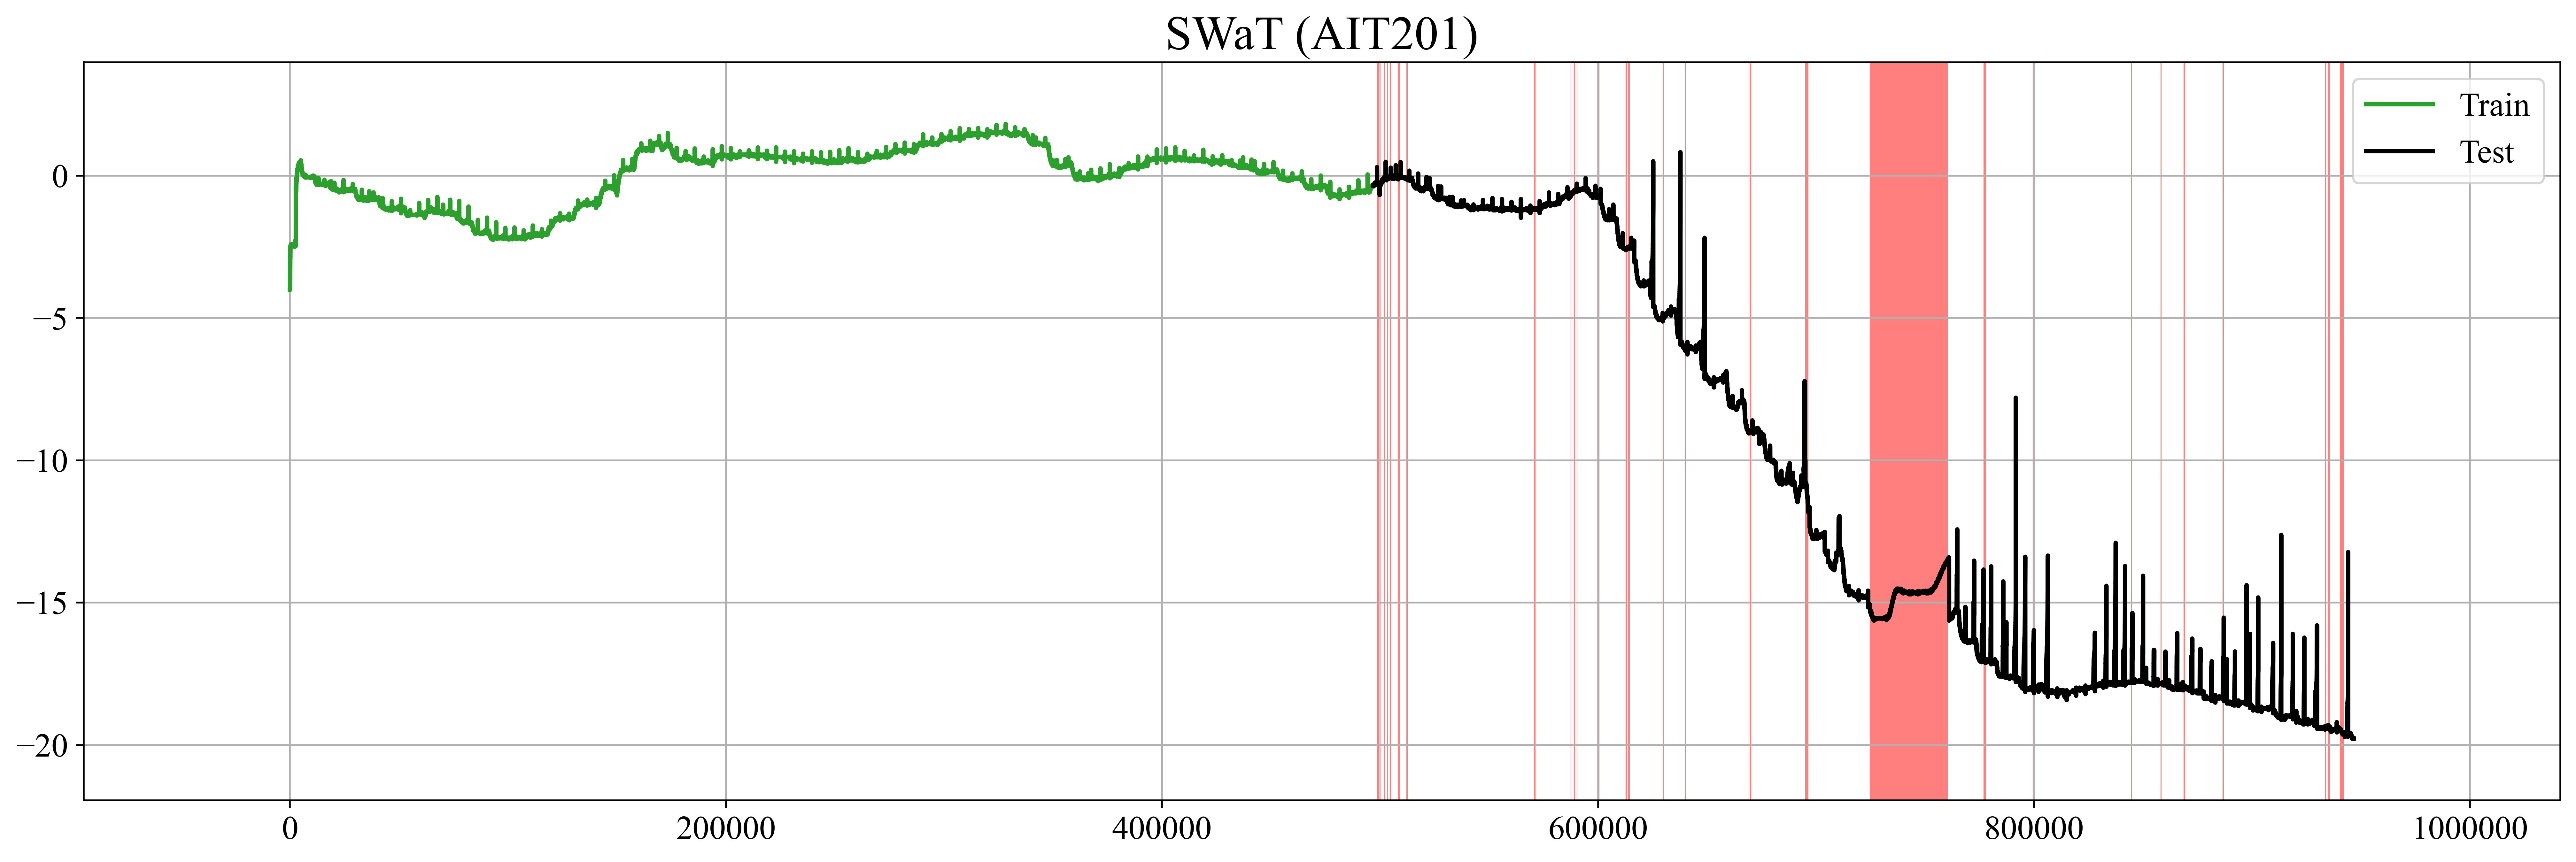

In [39]:
c = 5
dataset_name = "SWaT"

plt.figure(figsize=(20, 6), dpi=500)
plt.plot(train_X[:, c], color="C2", label="Train")
plt.plot(range(len(train_X), len(train_X)+len(test_X)), test_X[:, c], color="black", label="Test")
label = np.concatenate([np.array([0]*len(train_X)), test_y])
plot_interval(plt, label)
#plt.title(f"{dataset_name} ({cols[c]})")
plt.title(f"SWaT (AIT201)")

plt.legend()
plt.ticklabel_format(style="plain")
plt.show()

## distplot

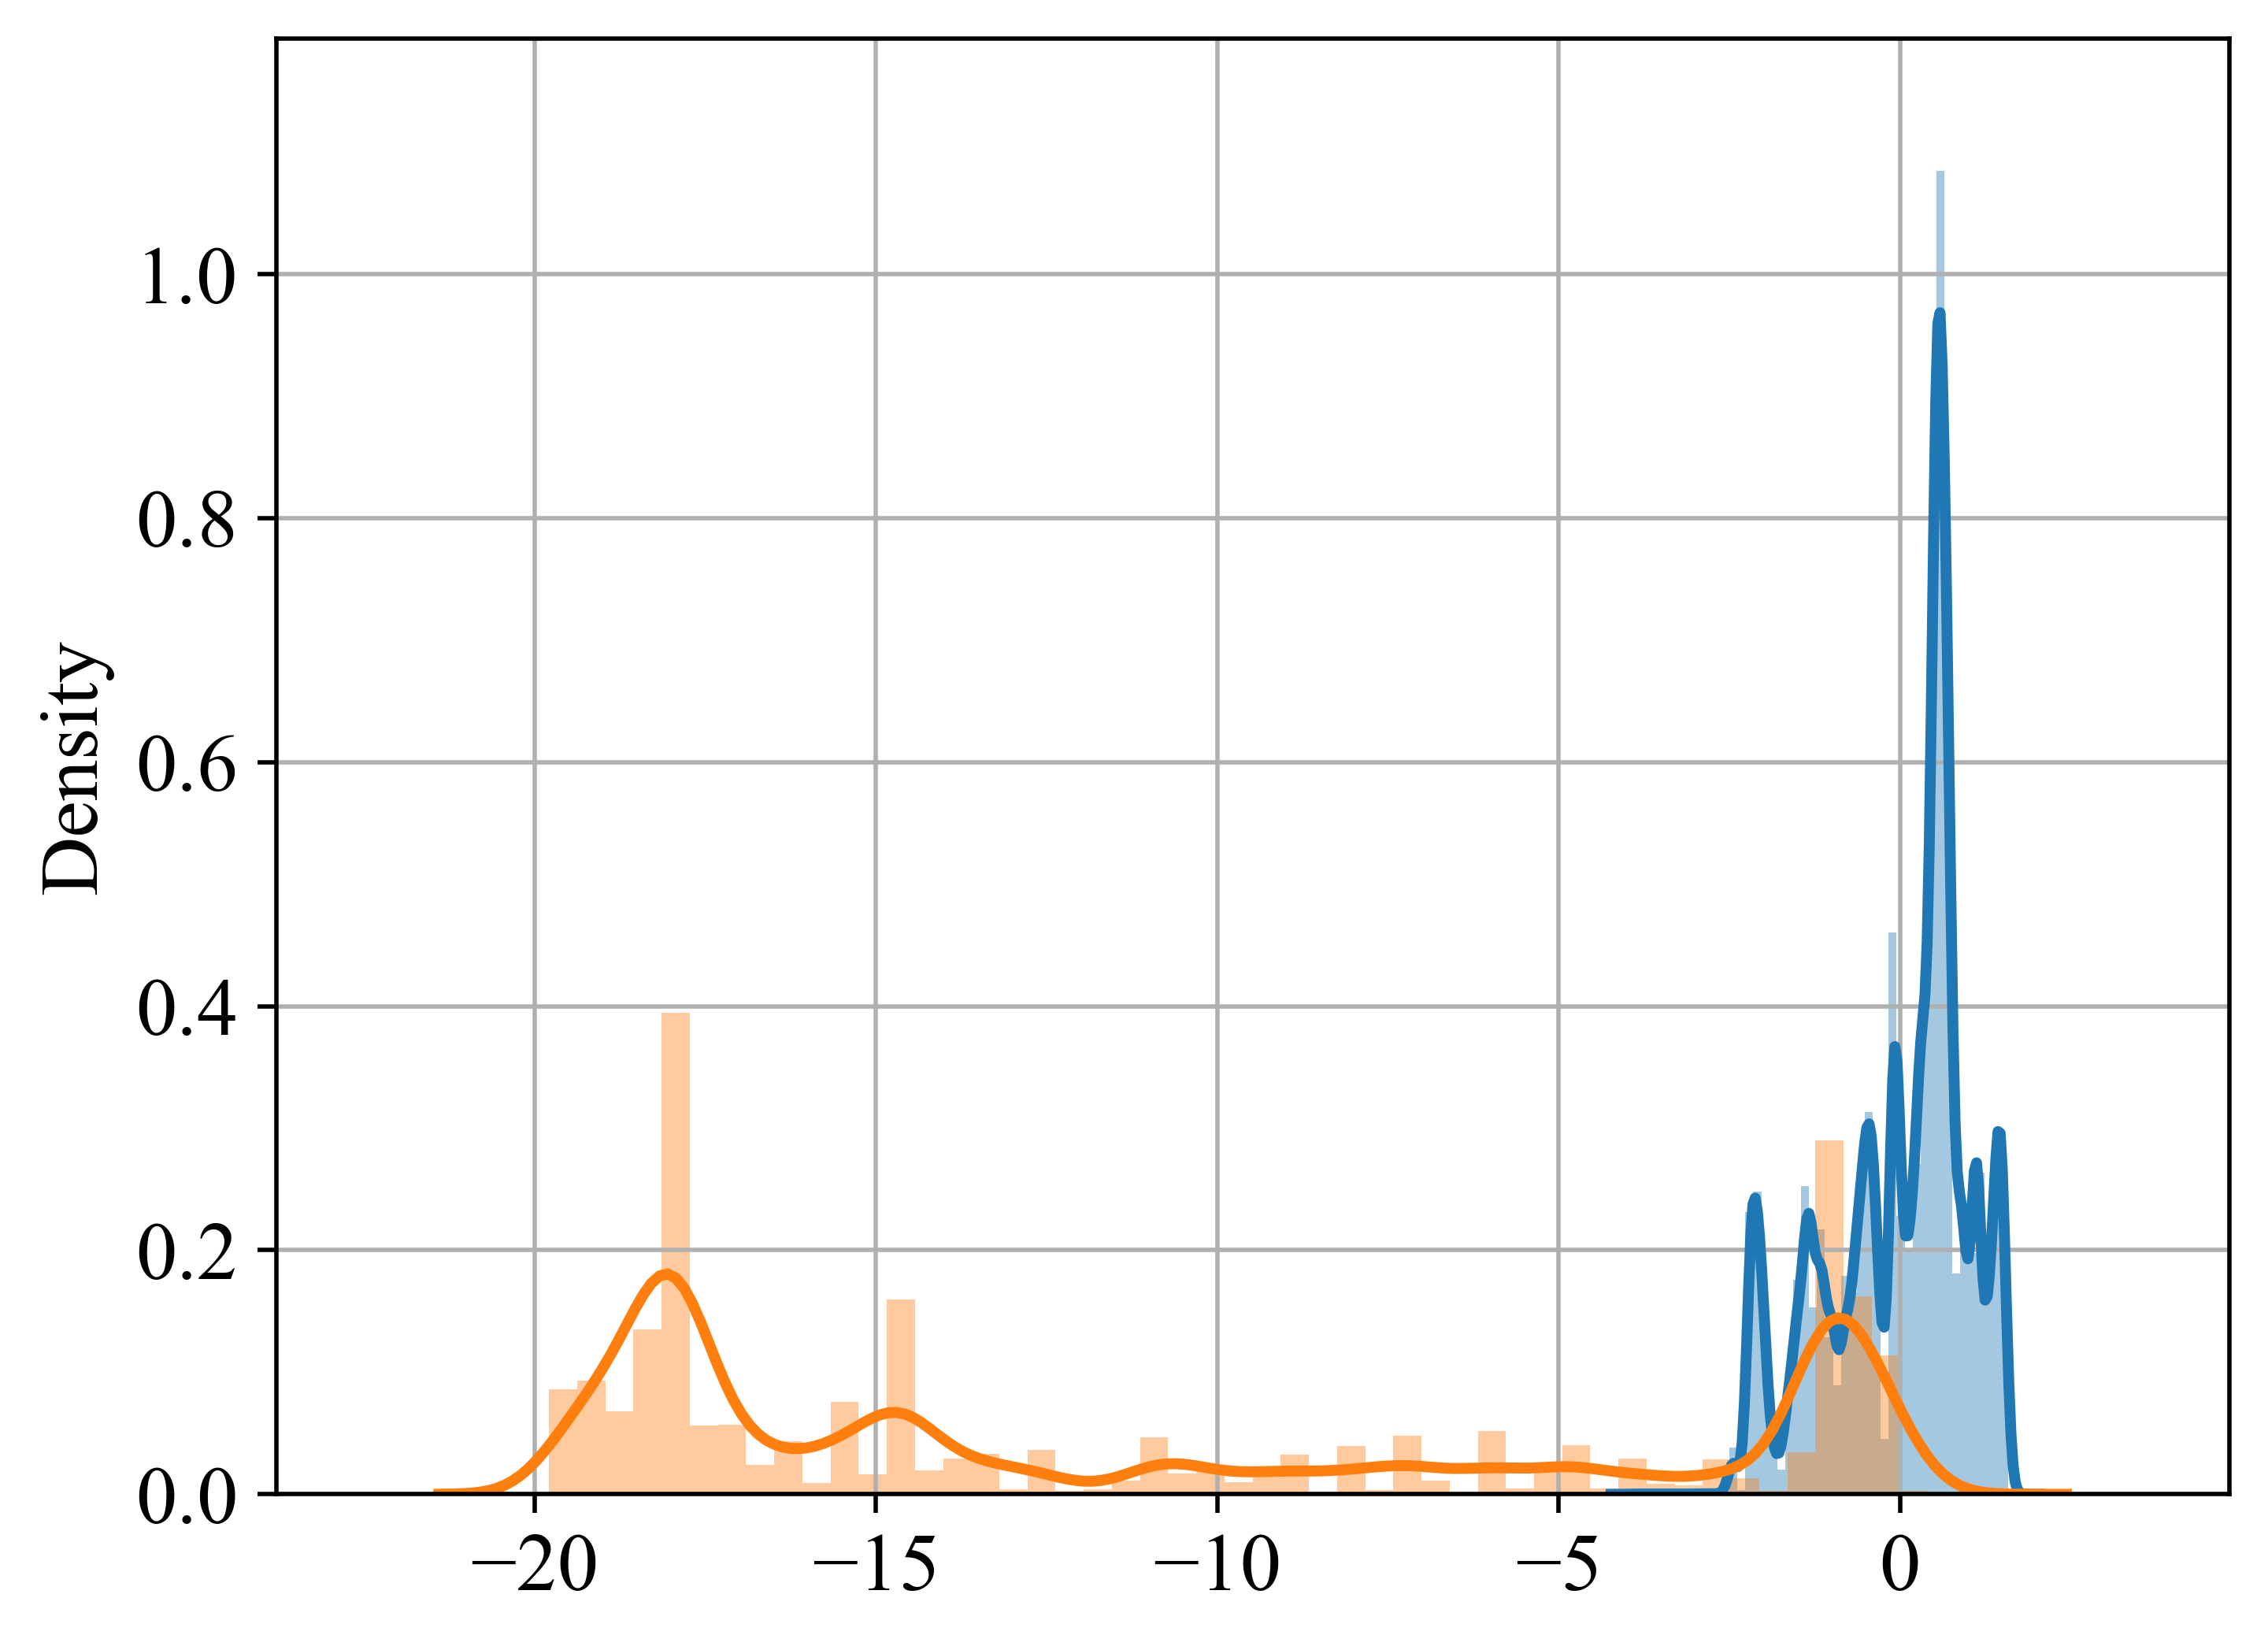

In [8]:
import seaborn as sns
c = 5
sns.distplot(train_X[:, c])
sns.distplot(test_X[:, c])
plt.show()

## PCA plots

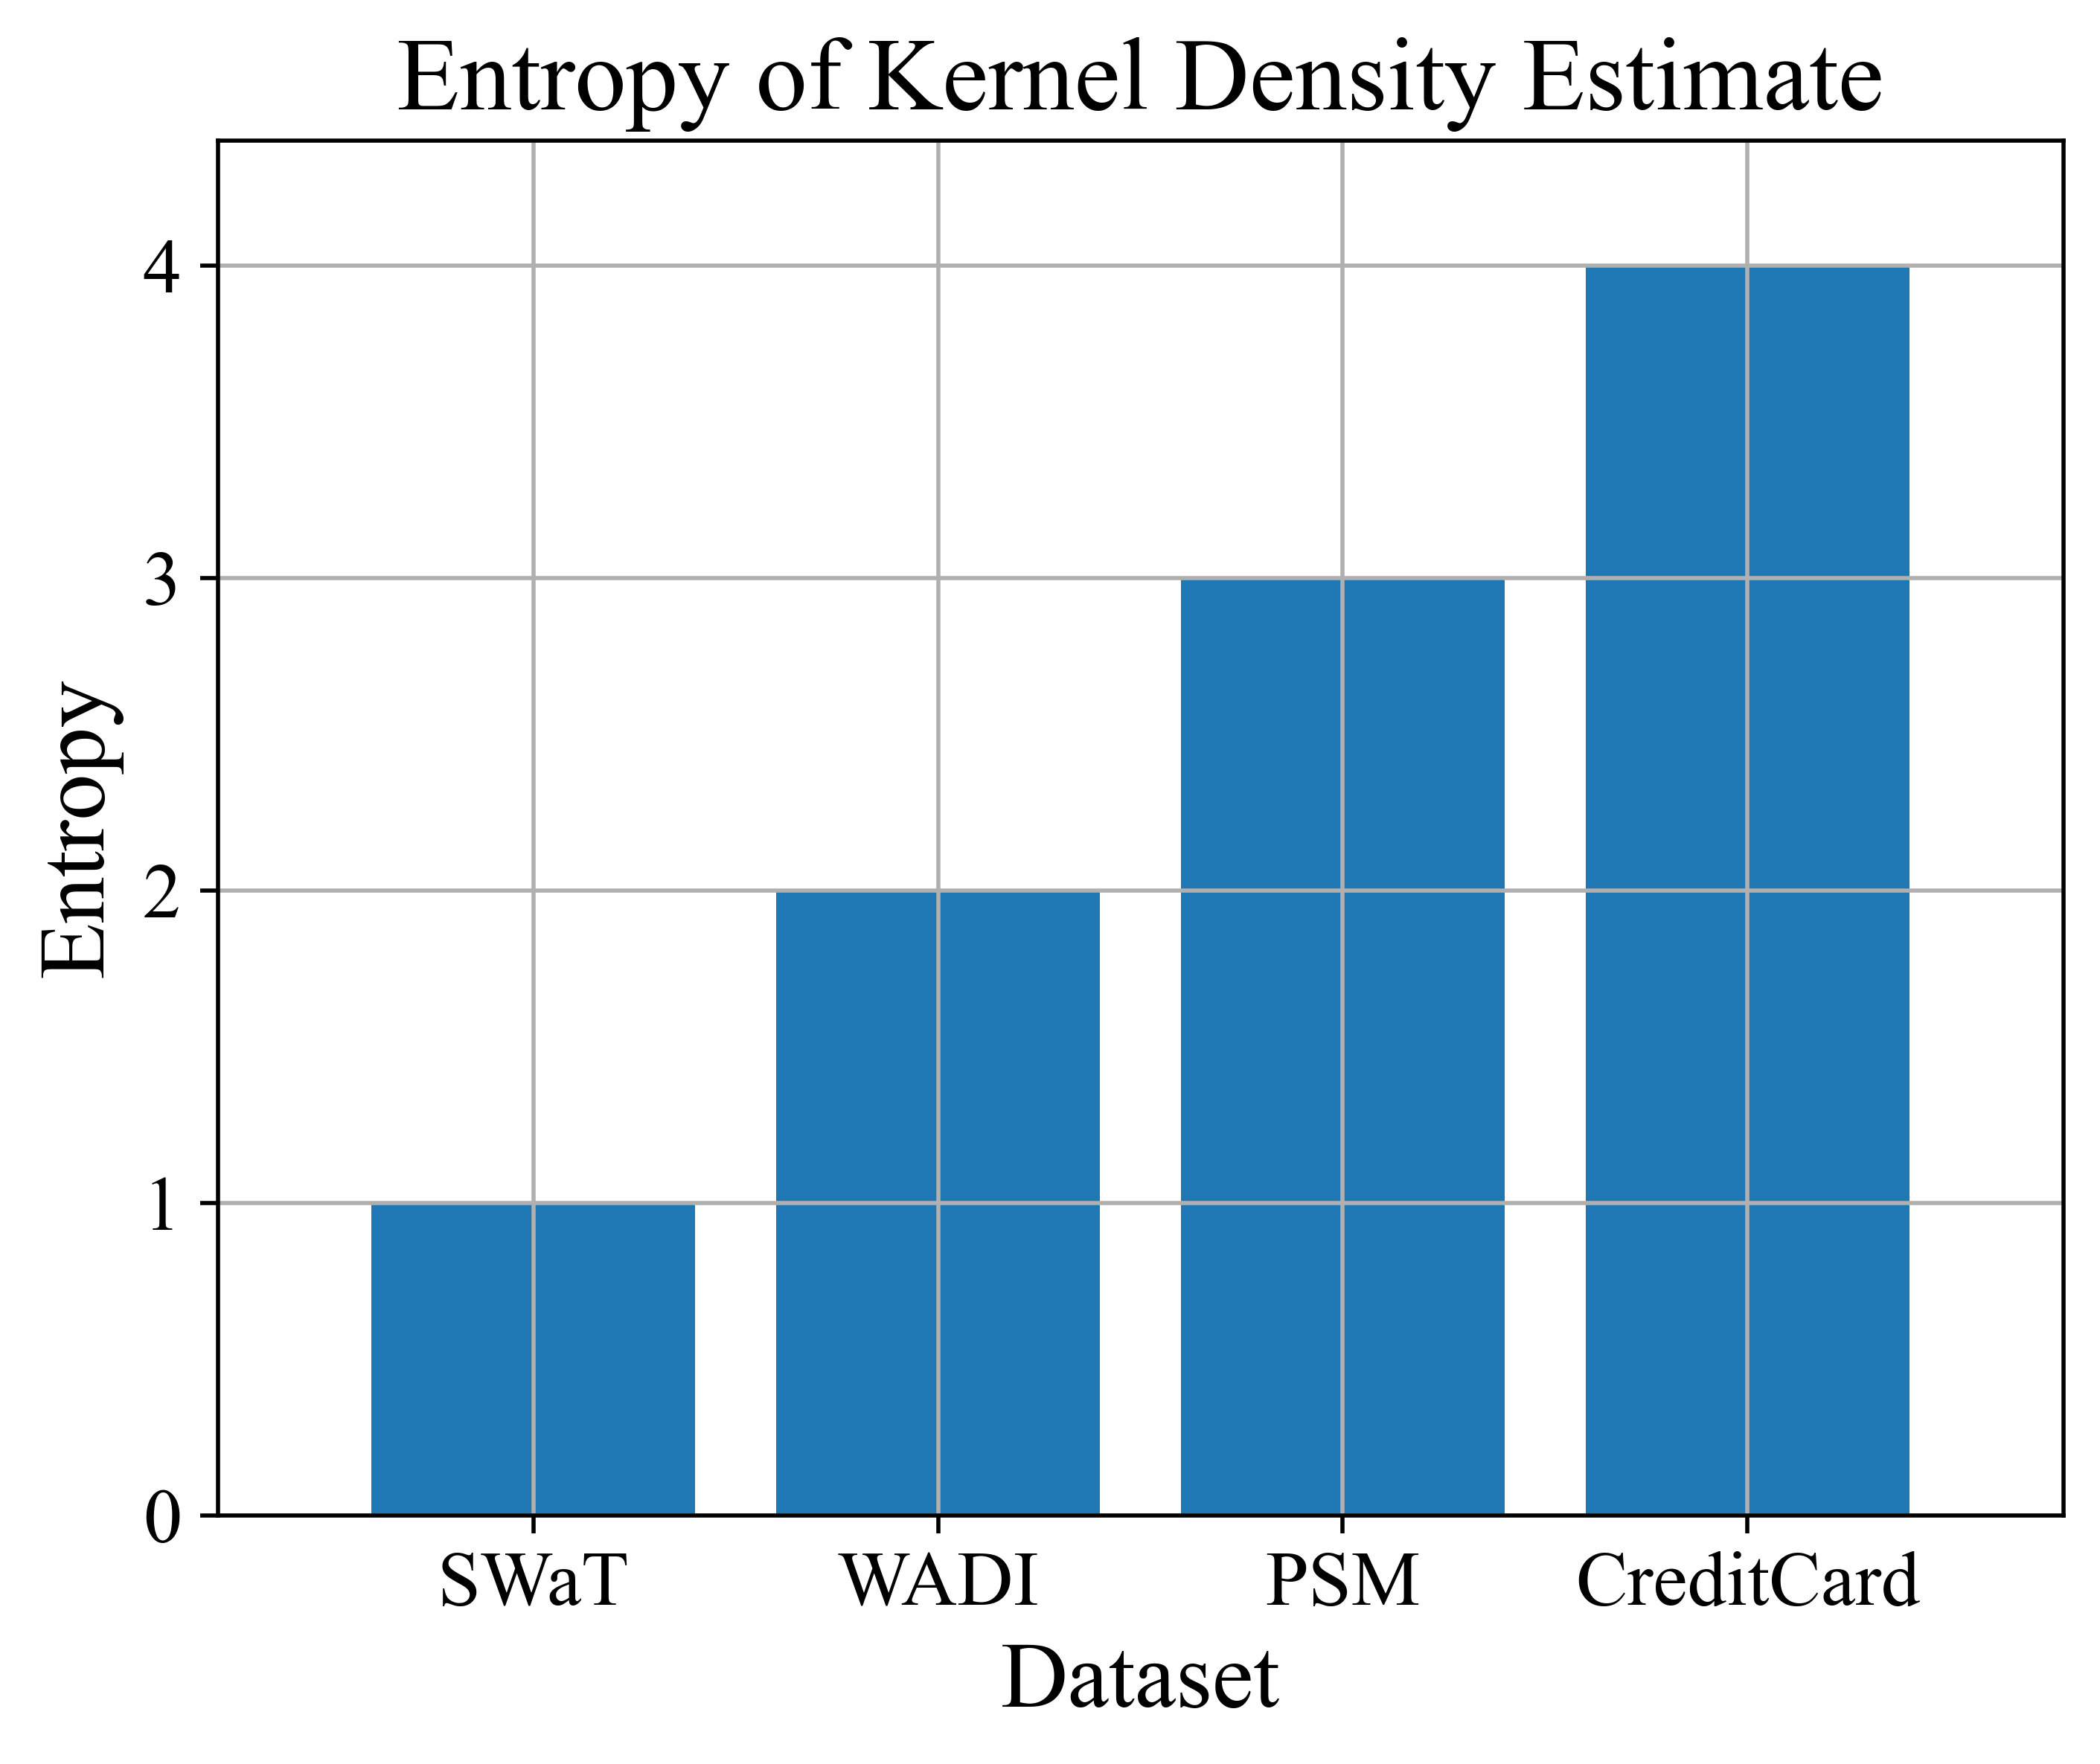

In [75]:
def plot_pcavar_return_entropy(train_X, train_y, test_X, test_y):
    print("finding PCA...")
    T, C = train_X.shape
    x = range(1, min(C, 31))
    n_ = 0
    for n in x:
        pca = PCA(n_components=n)
        Xpca = pca.fit_transform(train_X)
        #print(Xpca.shape)
        #print(pca.explained_variance_ratio_)
        evar.append(sum(pca.explained_variance_ratio_))
        if n_ == 0 and sum(pca.explained_variance_ratio_) > 0.99 :
            n_ = n
    print("Done!")
    plt.plot(x, evar)
    plt.axvline(n_)
    plt.show()
    
    import pdb;pdb.set_trace();
    
    # kde of PCA'ed outputs.
    pca = PCA(n_components=n_) 
    Xpca_train = pca.fit_transform(train_X)
    Xpca_test = pca.fit_transform(test_X)
    
    Xm = np.concatenate([Xpca_train, Xpca_test]).min(axis=0)
    XM = np.concatenate([Xpca_train, Xpca_test]).max(axis=0)
    
    grid = np.linspace(Xm, XM, 100).T
    
    e = entropy(test_kde(grid), train_kde(grid)) # how much information should be gained, from train, to test.
    print(e)
    print("="*20)
    return e

finding PCA...
Done!


ValueError: x and y must have same first dimension, but have shapes (30,) and (60,)

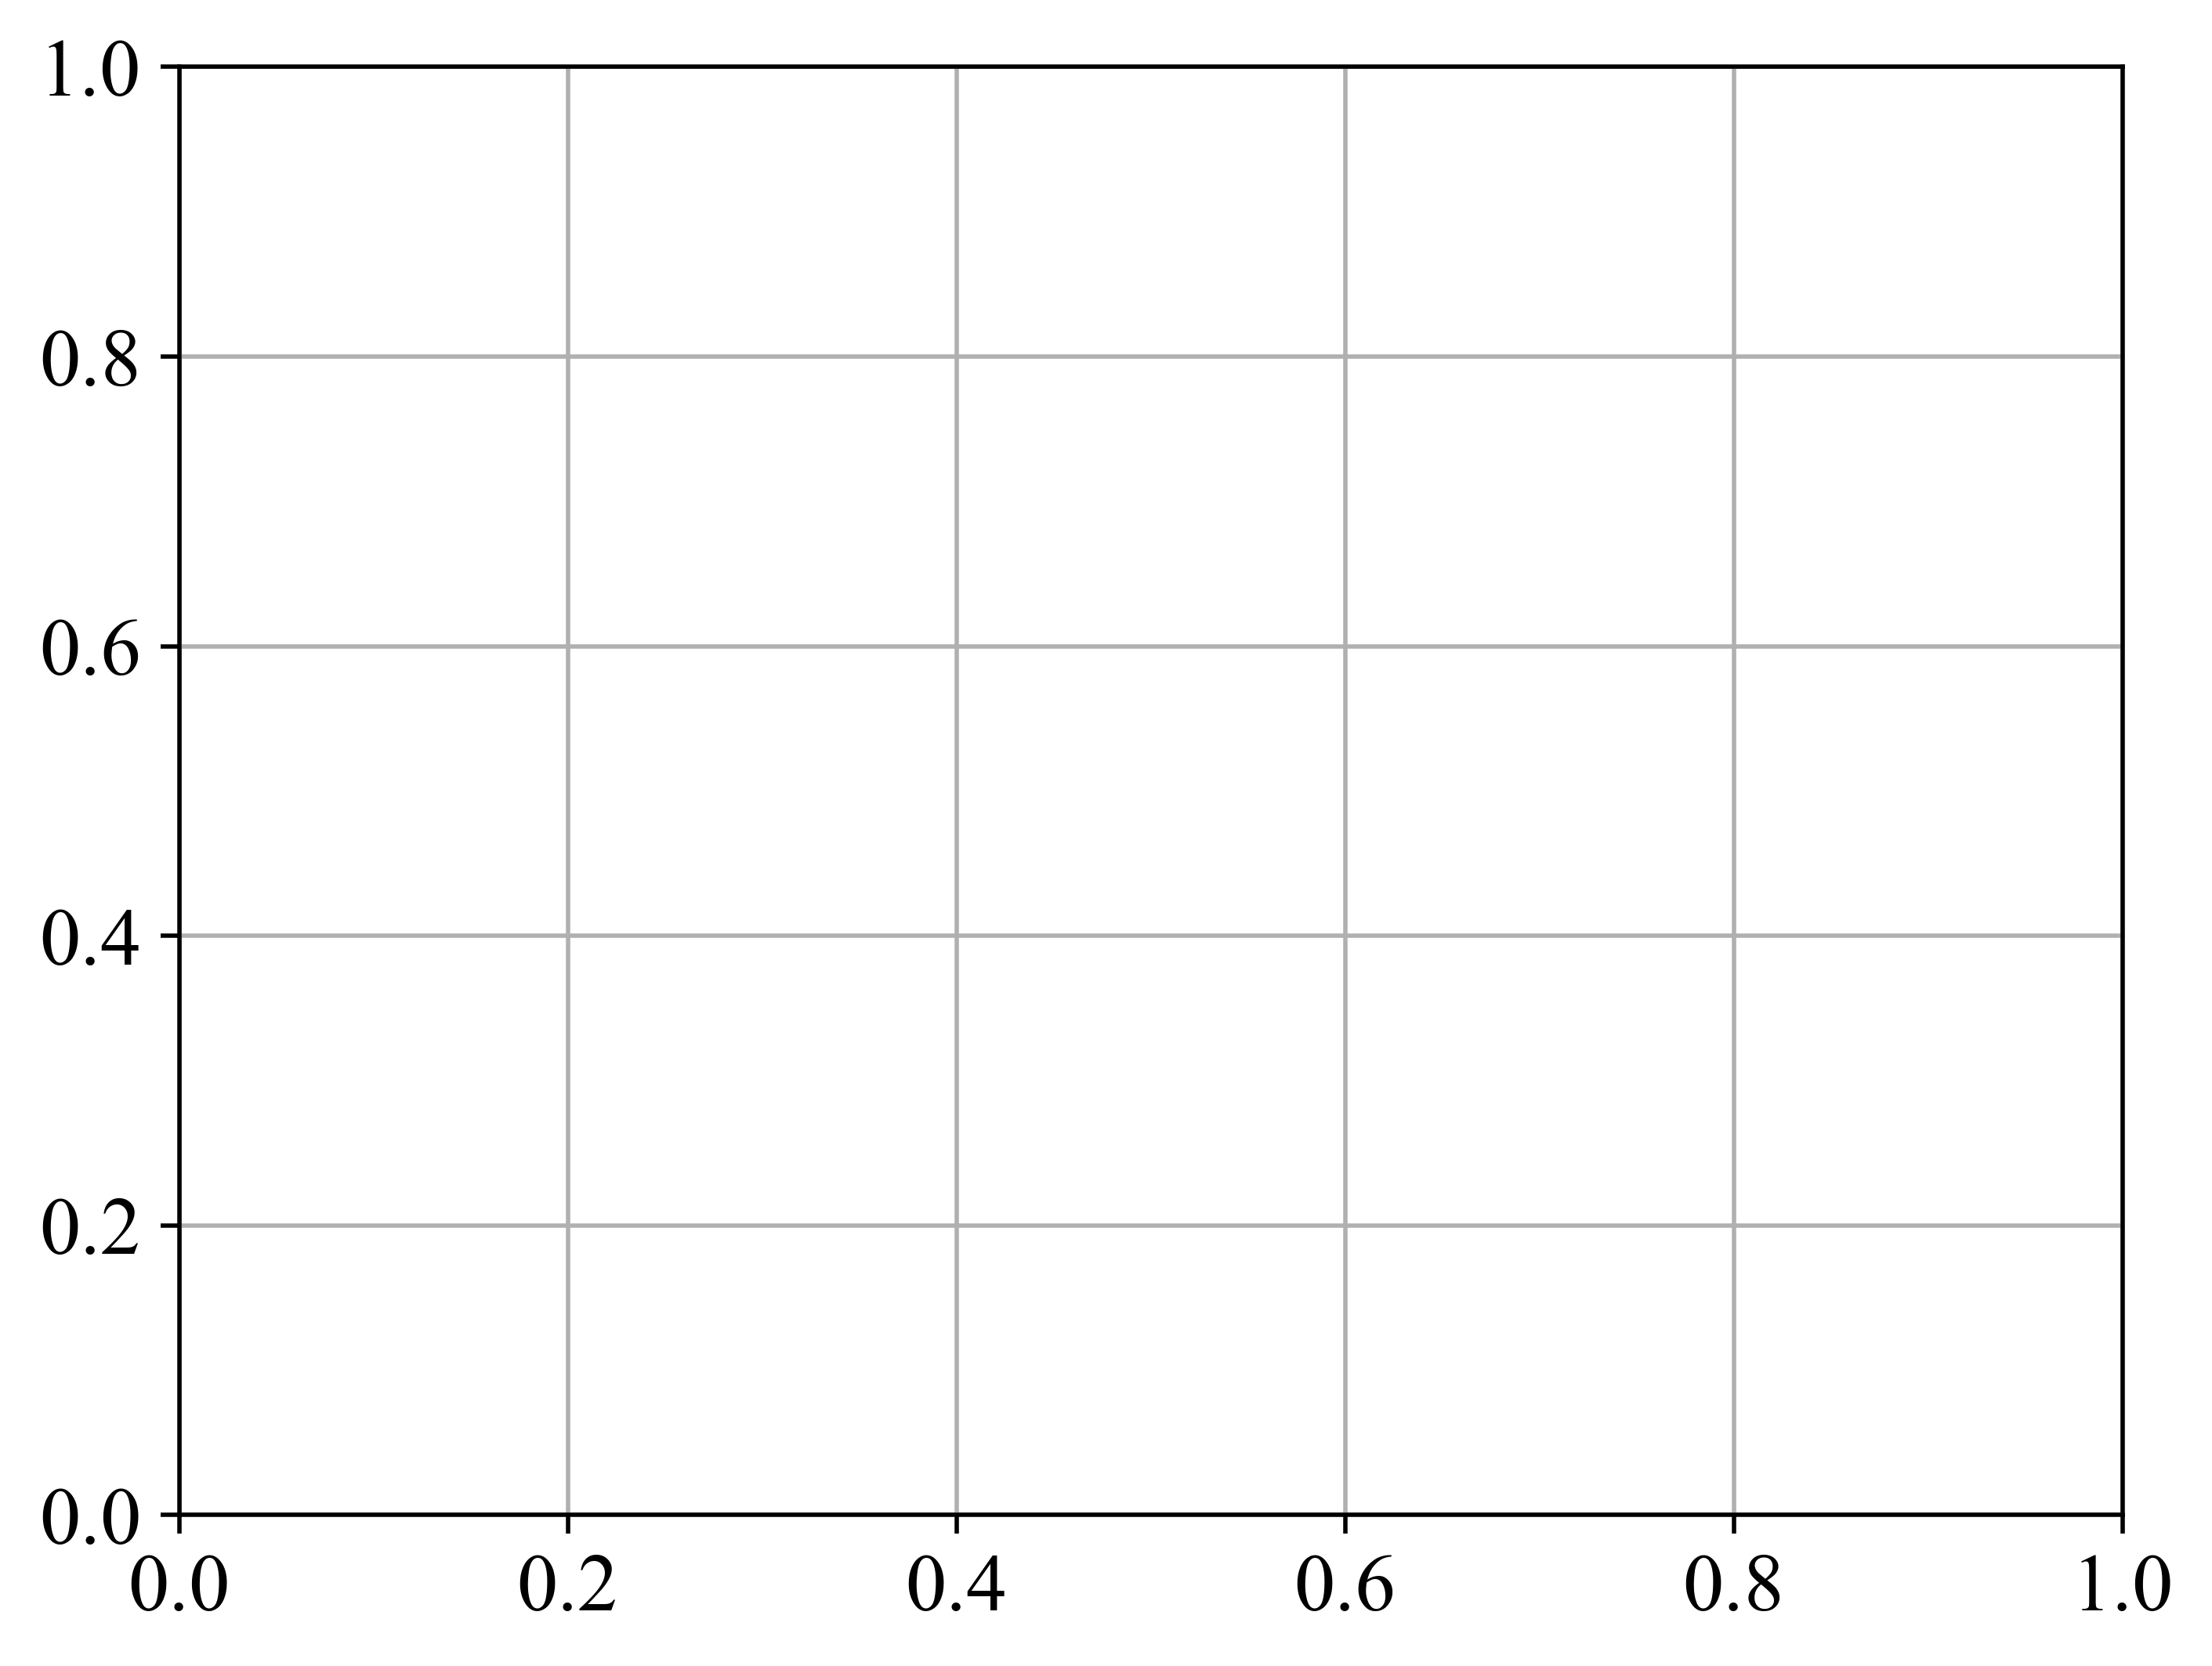

In [76]:

datasets = ["SWaT", "WADI", "PSM", "CreditCard"]
entropies = []
# SWaT
train_X, train_y, test_X, test_y = DataFactory.load_SWaT()
e = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y)
entropies.append(e)

# SWaT
train_X, train_y, test_X, test_y = DataFactory.load_WADI()
e = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y)
entropies.append(e)

# PSM
train_X, train_y, test_X, test_y = DataFactory.load_PSM()
e = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y)
entropies.append(e)

# CreditCard
train_X, train_y, test_X, test_y = DataFactory.load_CreditCard()
e = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y)
entropies.append(e)

<function DataFactory.load_PSM at 0x00000256C6230430>
(132481, 25) (132481,) (87841, 25) (87841,)
finding PCA...
Done!


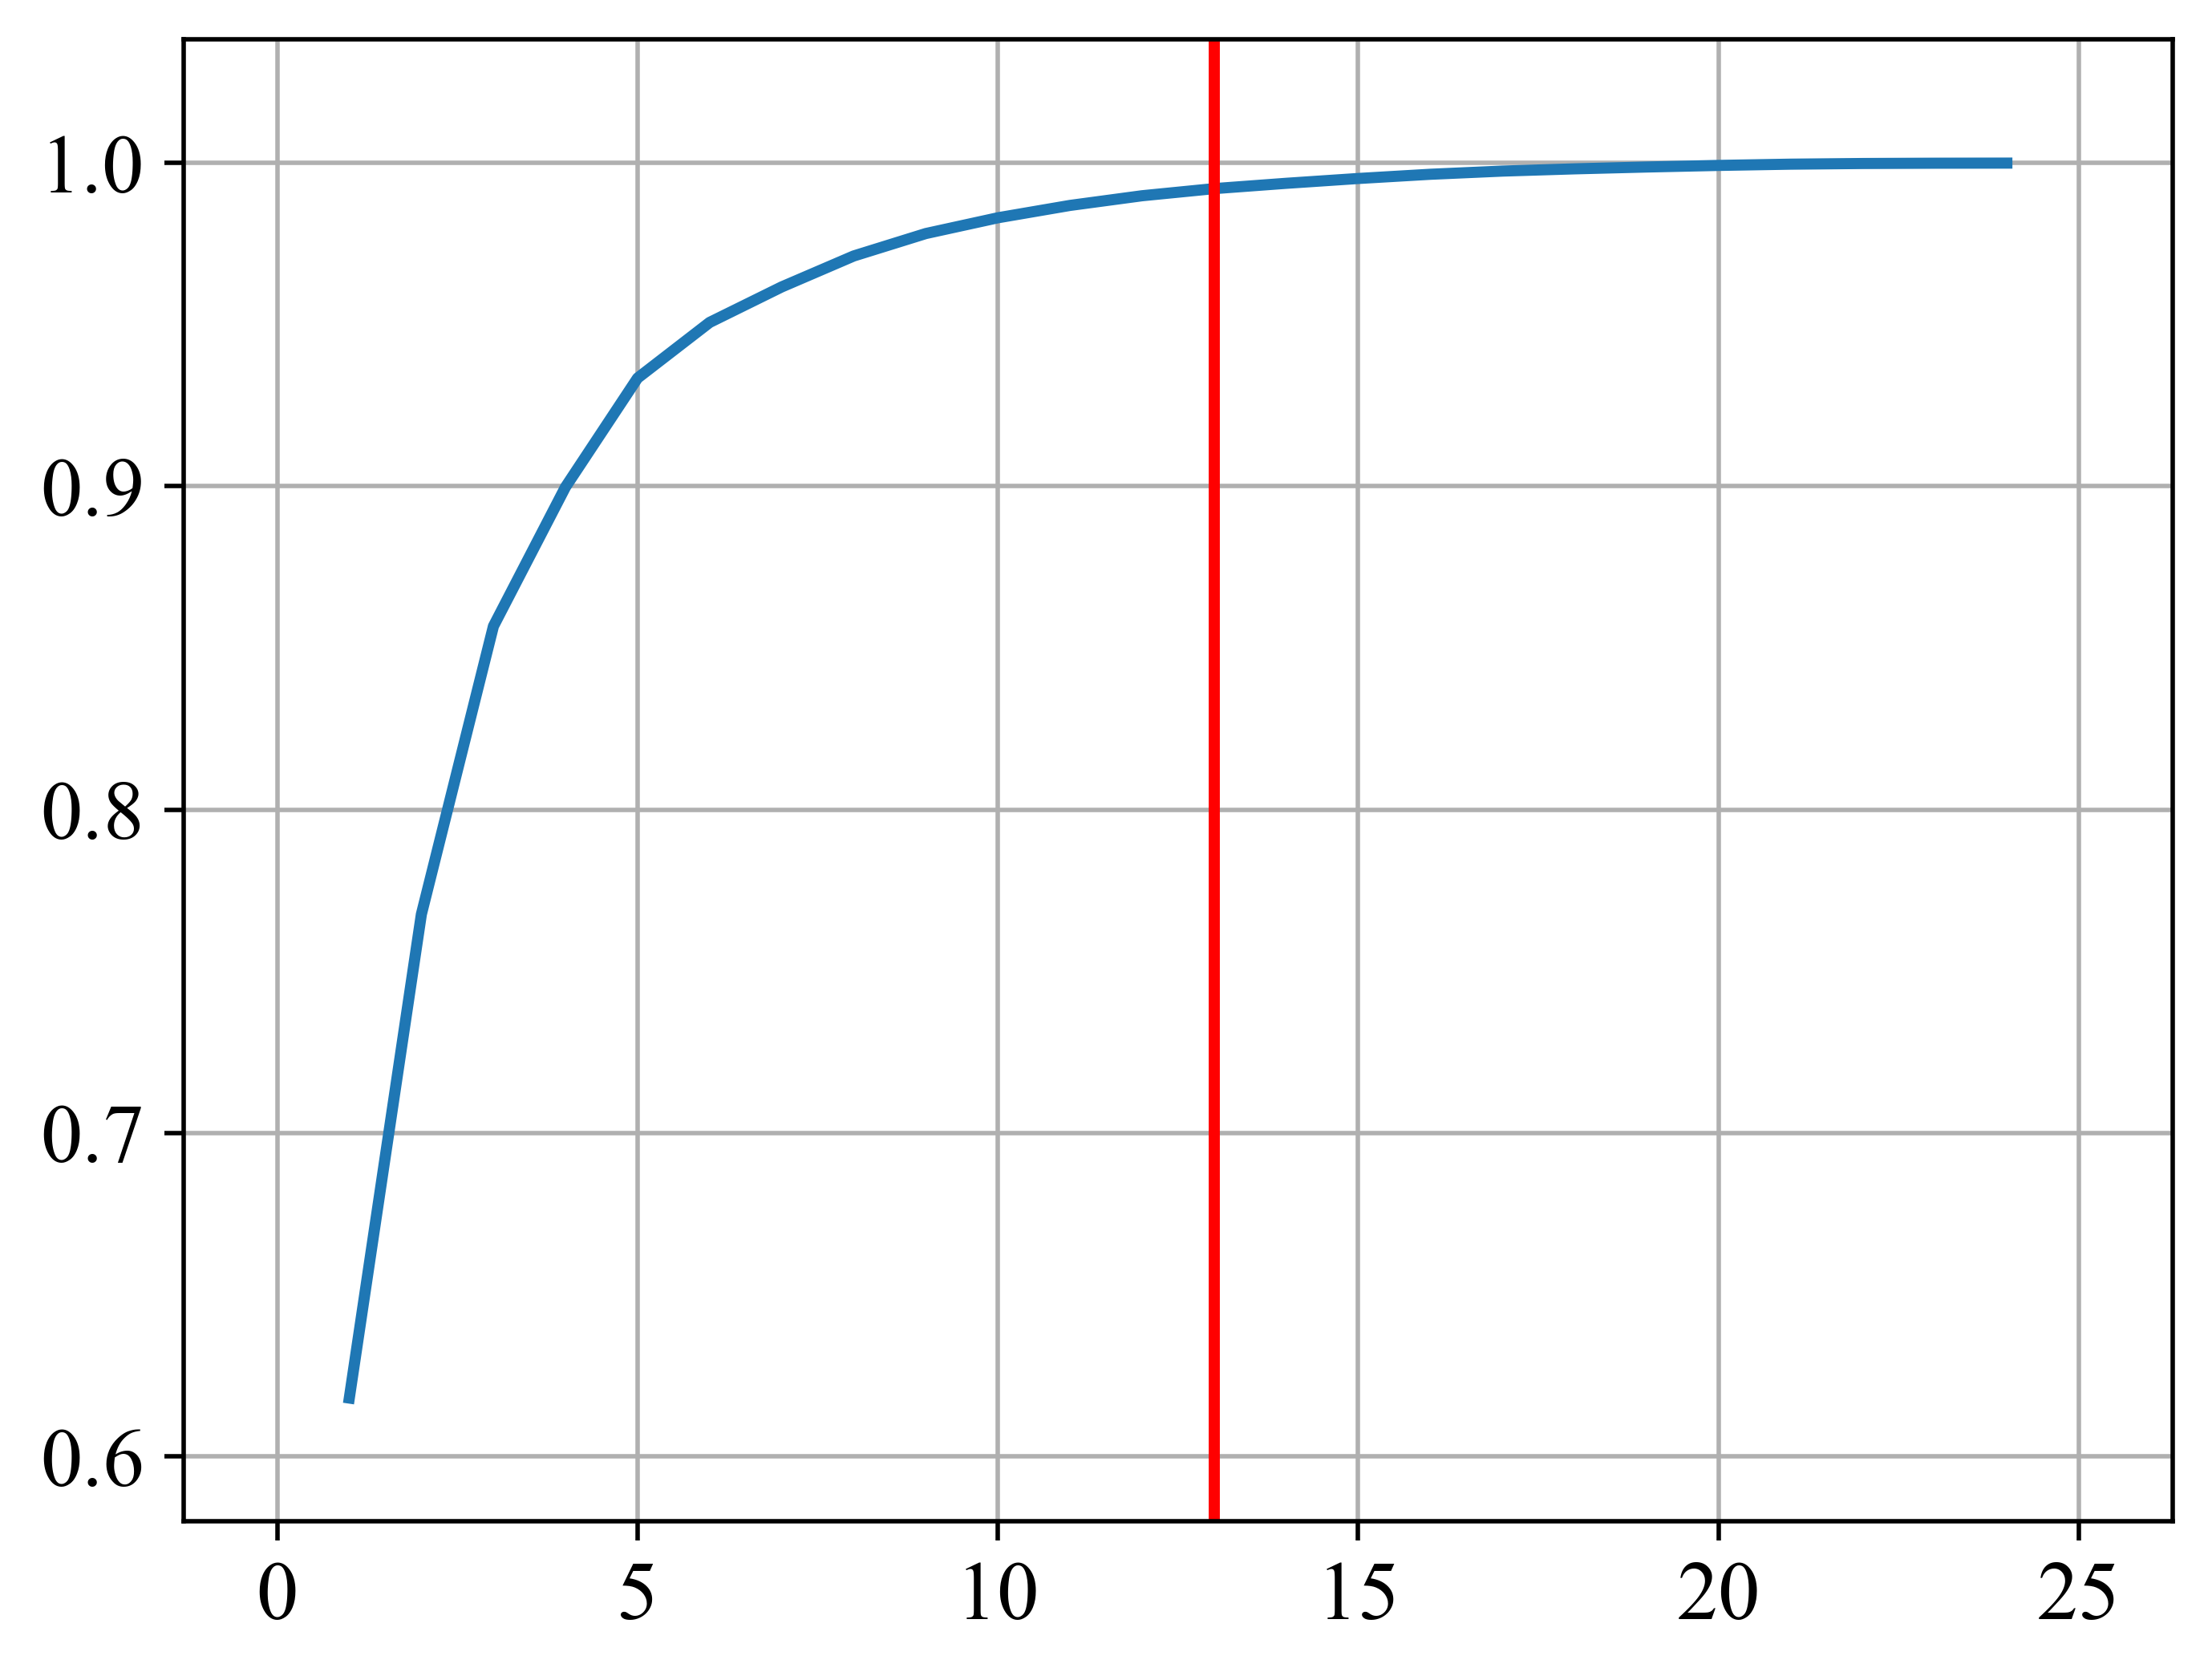

> c:\users\dongmin kim\appdata\local\temp\ipykernel_2140\907796560.py(31)<module>()

ipdb> l
     26     plt.show()
     27 
     28     import pdb;pdb.set_trace();
     29 
     30     # kde of PCA'ed outputs.
---> 31     pca = PCA(n_components=n_)
     32     Xpca_train = pca.fit_transform(train_X)
     33     Xpca_test = pca.fit_transform(test_X)
     34 
     35     Xm = np.concatenate([Xpca_train, Xpca_test]).min(axis=0)
     36     XM = np.concatenate([Xpca_train, Xpca_test]).max(axis=0)

ipdb> n_
13
ipdb> n
> c:\users\dongmin kim\appdata\local\temp\ipykernel_2140\907796560.py(32)<module>()

ipdb> l
     27 
     28     import pdb;pdb.set_trace();
     29 
     30     # kde of PCA'ed outputs.
     31     pca = PCA(n_components=n_)
---> 32     Xpca_train = pca.fit_transform(train_X)
     33     Xpca_test = pca.fit_transform(test_X)
     34 
     35     Xm = np.concatenate([Xpca_train, Xpca_test]).min(axis=0)
     36     XM = np.concatenate([Xpca_train, Xpca_test]).max(axis=0)
    

ipdb> n
> c:\users\dongmin kim\appdata\local\temp\ipykernel_2140\907796560.py(41)<module>()

ipdb> l
     36     XM = np.concatenate([Xpca_train, Xpca_test]).max(axis=0)
     37 
     38     grid = np.linspace(Xm, XM, 100).T
     39 
     40     e = entropy(test_kde(grid), train_kde(grid)) # how much information should be gained, from train, to test.
---> 41     print(e)
     42     entropies.append(e)
     43     print("="*20)
     44 
     45 # Basic Bar Chart
     46 plt.bar(datasets, entropies)

ipdb> n
0.0349110177453517
> c:\users\dongmin kim\appdata\local\temp\ipykernel_2140\907796560.py(42)<module>()

ipdb> n
> c:\users\dongmin kim\appdata\local\temp\ipykernel_2140\907796560.py(43)<module>()

ipdb> l
     38     grid = np.linspace(Xm, XM, 100).T
     39 
     40     e = entropy(test_kde(grid), train_kde(grid)) # how much information should be gained, from train, to test.
     41     print(e)
     42     entropies.append(e)
---> 43     print("="*20)
     44 
     45 # Basic Bar 

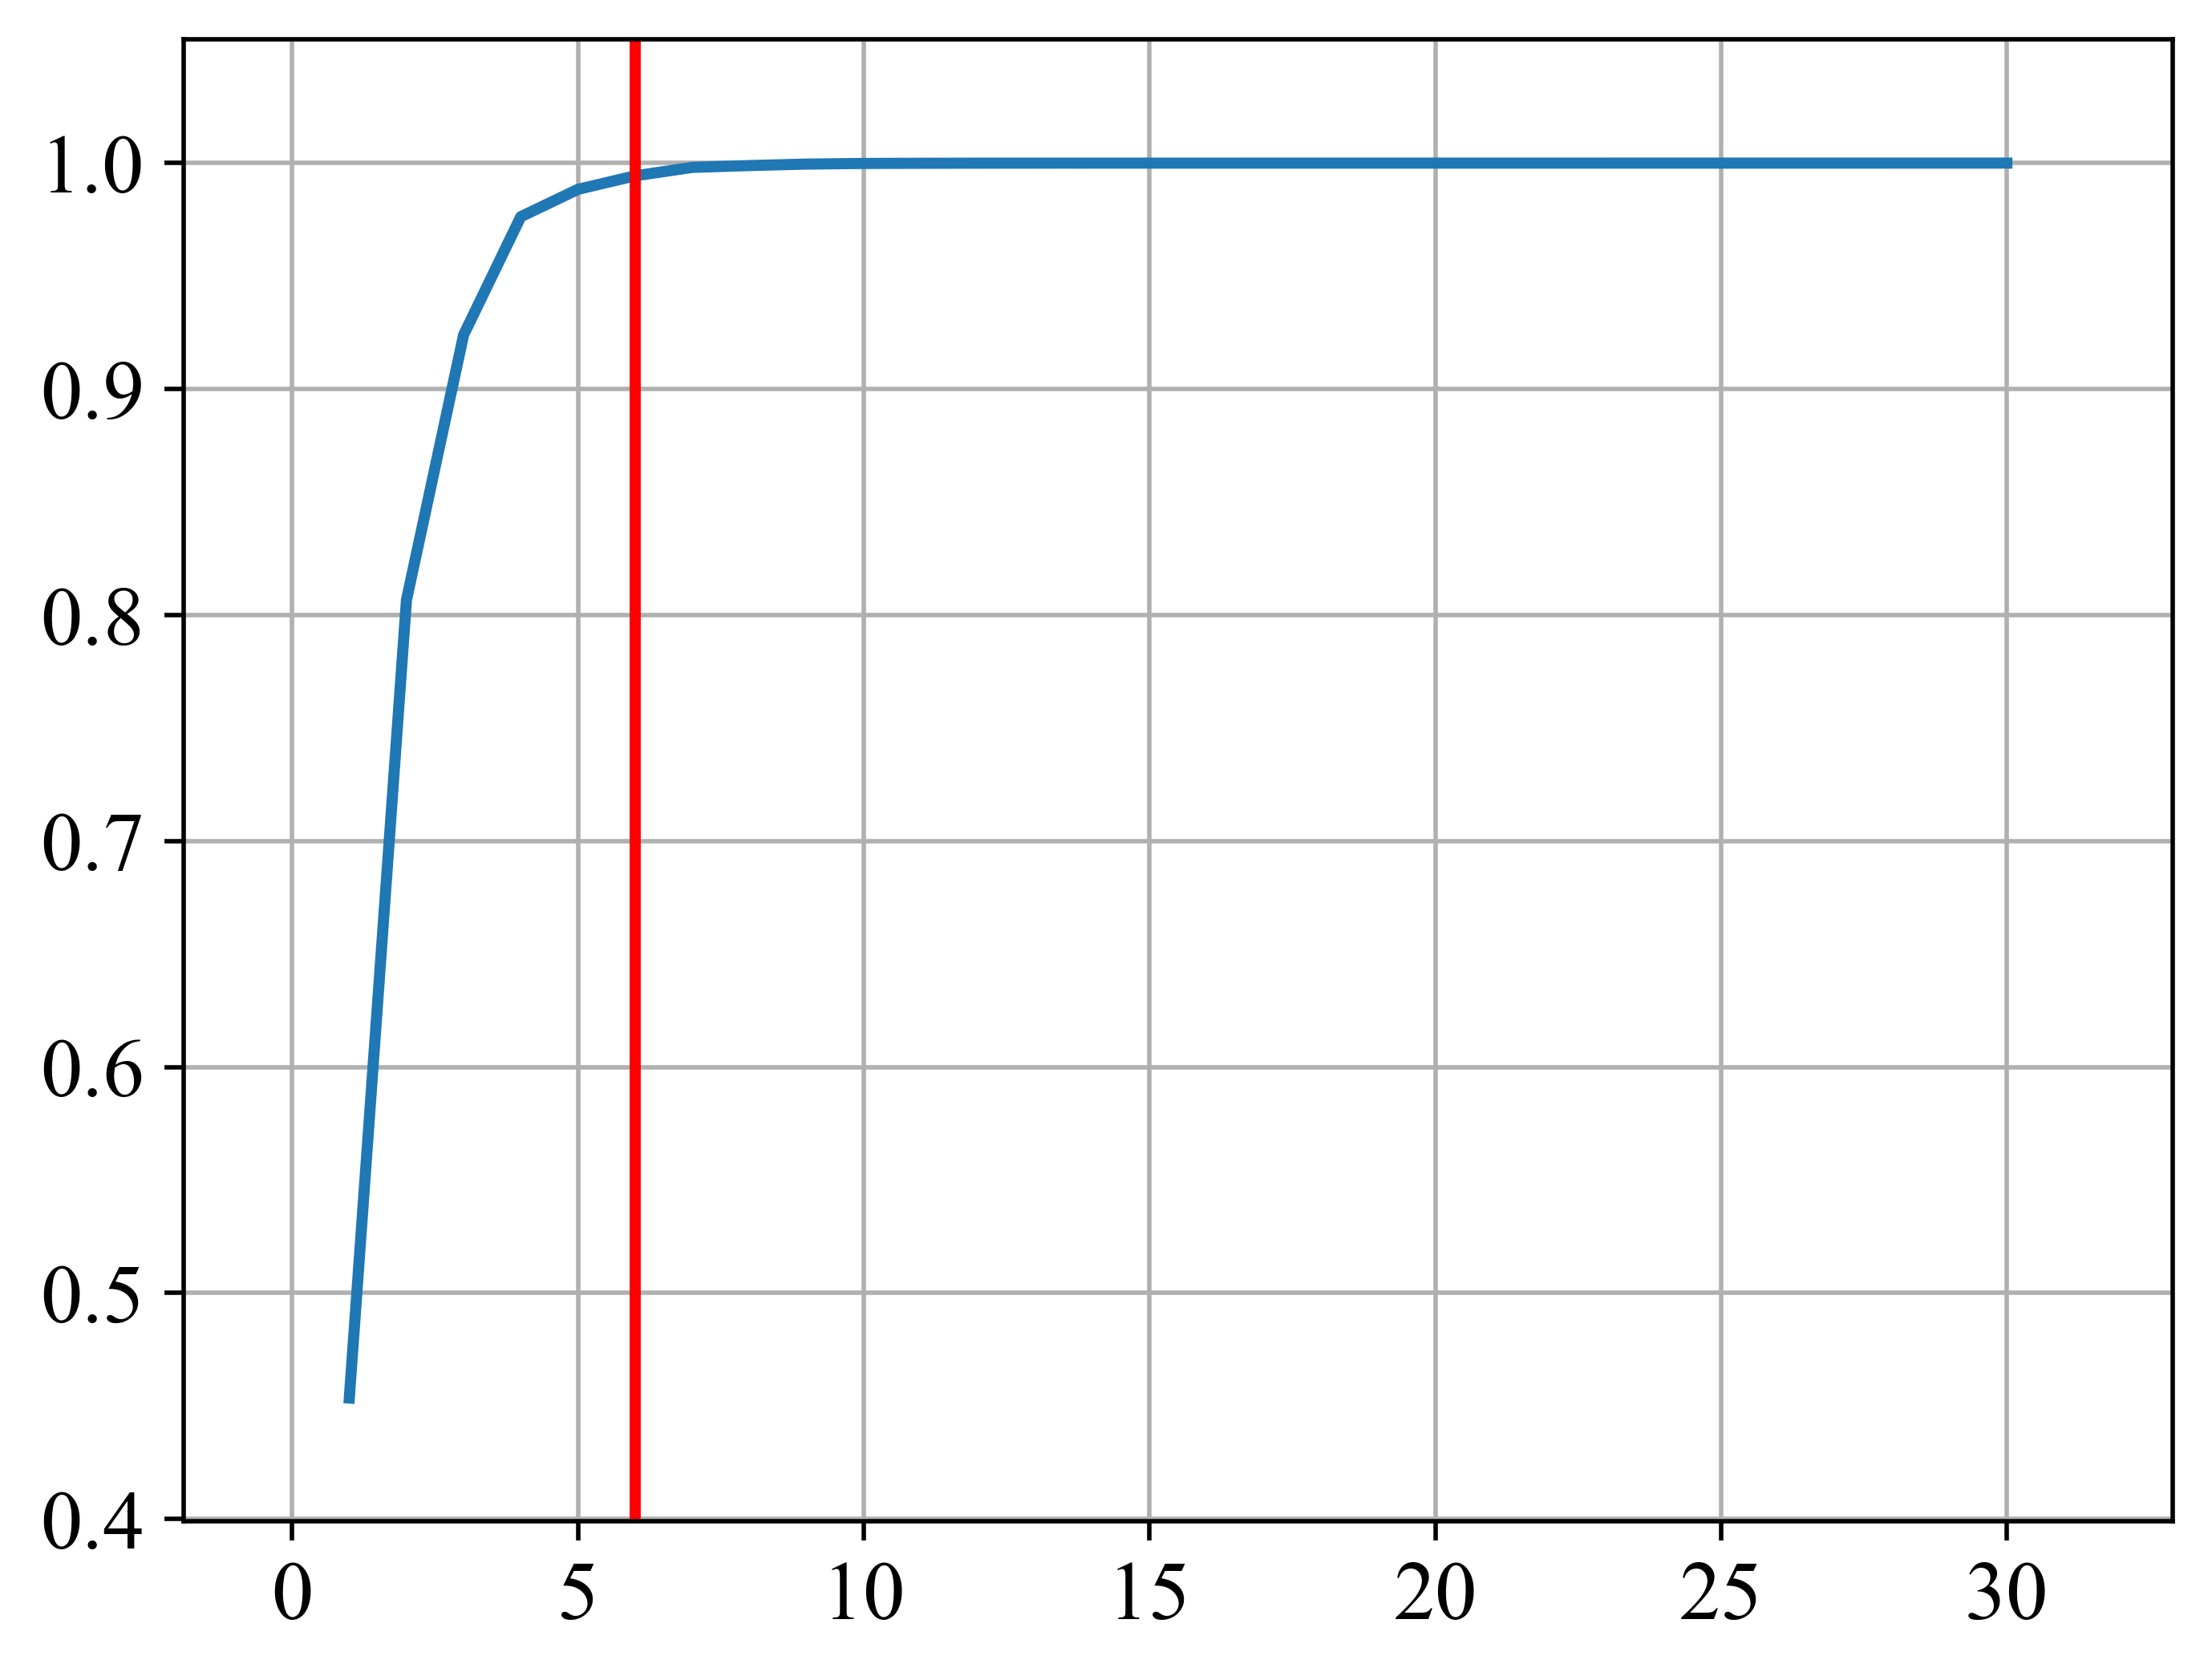

> c:\users\dongmin kim\appdata\local\temp\ipykernel_2140\907796560.py(31)<module>()

ipdb> l
     26     plt.show()
     27 
     28     import pdb;pdb.set_trace();
     29 
     30     # kde of PCA'ed outputs.
---> 31     pca = PCA(n_components=n_)
     32     Xpca_train = pca.fit_transform(train_X)
     33     Xpca_test = pca.fit_transform(test_X)
     34 
     35     Xm = np.concatenate([Xpca_train, Xpca_test]).min(axis=0)
     36     XM = np.concatenate([Xpca_train, Xpca_test]).max(axis=0)

ipdb> n_
6
ipdb> n
> c:\users\dongmin kim\appdata\local\temp\ipykernel_2140\907796560.py(32)<module>()

ipdb> l
     27 
     28     import pdb;pdb.set_trace();
     29 
     30     # kde of PCA'ed outputs.
     31     pca = PCA(n_components=n_)
---> 32     Xpca_train = pca.fit_transform(train_X)
     33     Xpca_test = pca.fit_transform(test_X)
     34 
     35     Xm = np.concatenate([Xpca_train, Xpca_test]).min(axis=0)
     36     XM = np.concatenate([Xpca_train, Xpca_test]).max(axis=0)
     

ipdb> pca = PCA(n_components=n_)      Xpca_train = pca.fit_transform(train_X)     Xpca_test = pca.fit_transform(test_X)
*** SyntaxError: invalid syntax
ipdb> pca = PCA(n_components=n_)
ipdb> Xpca_train = pca.fit_transform(train_X)
ipdb> Xpca_test = pca.fit_transform(test_X)
ipdb> Xm = np.concatenate([Xpca_train, Xpca_test]).min(axis=0)
ipdb> XM = np.concatenate([Xpca_train, Xpca_test]).max(axis=0)
ipdb> grid = np.linspace(Xm, XM, 100).T
ipdb> test_kde(grid)
*** ValueError: points have dimension 6, dataset has dimension 13
ipdb> grid.shape
(6, 100)
ipdb> n_
6
ipdb> Xm.shape
(6,)
ipdb> pca
PCA(n_components=6)
ipdb> Xpca_train
array([[ 909.0223   , -227.87604  ,  -97.173744 , -162.17303  ,
         167.81676  ,   -2.0476708],
       [ 909.2129   , -227.50279  ,  -97.189514 , -162.28496  ,
         167.79207  ,   -2.0395455],
       [ 909.3989   , -227.31511  ,  -97.204254 , -162.40411  ,
         167.72699  ,   -2.0027637],
       ...,
       [ -41.036064 ,  100.01186  ,  -22.369629 ,  -1

In [73]:

entropies = []
fns = [DataFactory.load_PSM, DataFactory.load_SWaT, DataFactory.load_WADI, DataFactory.load_CreditCard]
for f in fns:
    print("="*20)
    print(f)
    train_X, train_y, test_X, test_y = f()
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    evar = []
    
    print("finding PCA...")
    T, C = train_X.shape
    x = range(1, min(C, 31))
    n_ = 0
    for n in x:
        pca = PCA(n_components=n)
        Xpca = pca.fit_transform(train_X)
        #print(Xpca.shape)
        #print(pca.explained_variance_ratio_)
        evar.append(sum(pca.explained_variance_ratio_))
        if n_ == 0 and sum(pca.explained_variance_ratio_) > 0.99 :
            n_ = n
    print("Done!")
    plt.plot(x, evar)
    plt.axvline(n_)
    plt.show()
    
    import pdb;pdb.set_trace();
    
    # kde of PCA'ed outputs.
    pca = PCA(n_components=n_) 
    Xpca_train = pca.fit_transform(train_X)
    Xpca_test = pca.fit_transform(test_X)
    
    Xm = np.concatenate([Xpca_train, Xpca_test]).min(axis=0)
    XM = np.concatenate([Xpca_train, Xpca_test]).max(axis=0)
    
    grid = np.linspace(Xm, XM, 100).T
    
    e = entropy(test_kde(grid), train_kde(grid)) # how much information should be gained, from train, to test.
    print(e)
    entropies.append(e)
    print("="*20)
    
# Basic Bar Chart
plt.bar(datasets, entropies)
plt.title('Entropy of Kernel Density Estimate', fontsize=20)
plt.xlabel('Dataset', fontsize=18)
plt.ylabel('Entropy', fontsize=18)
plt.show()
    

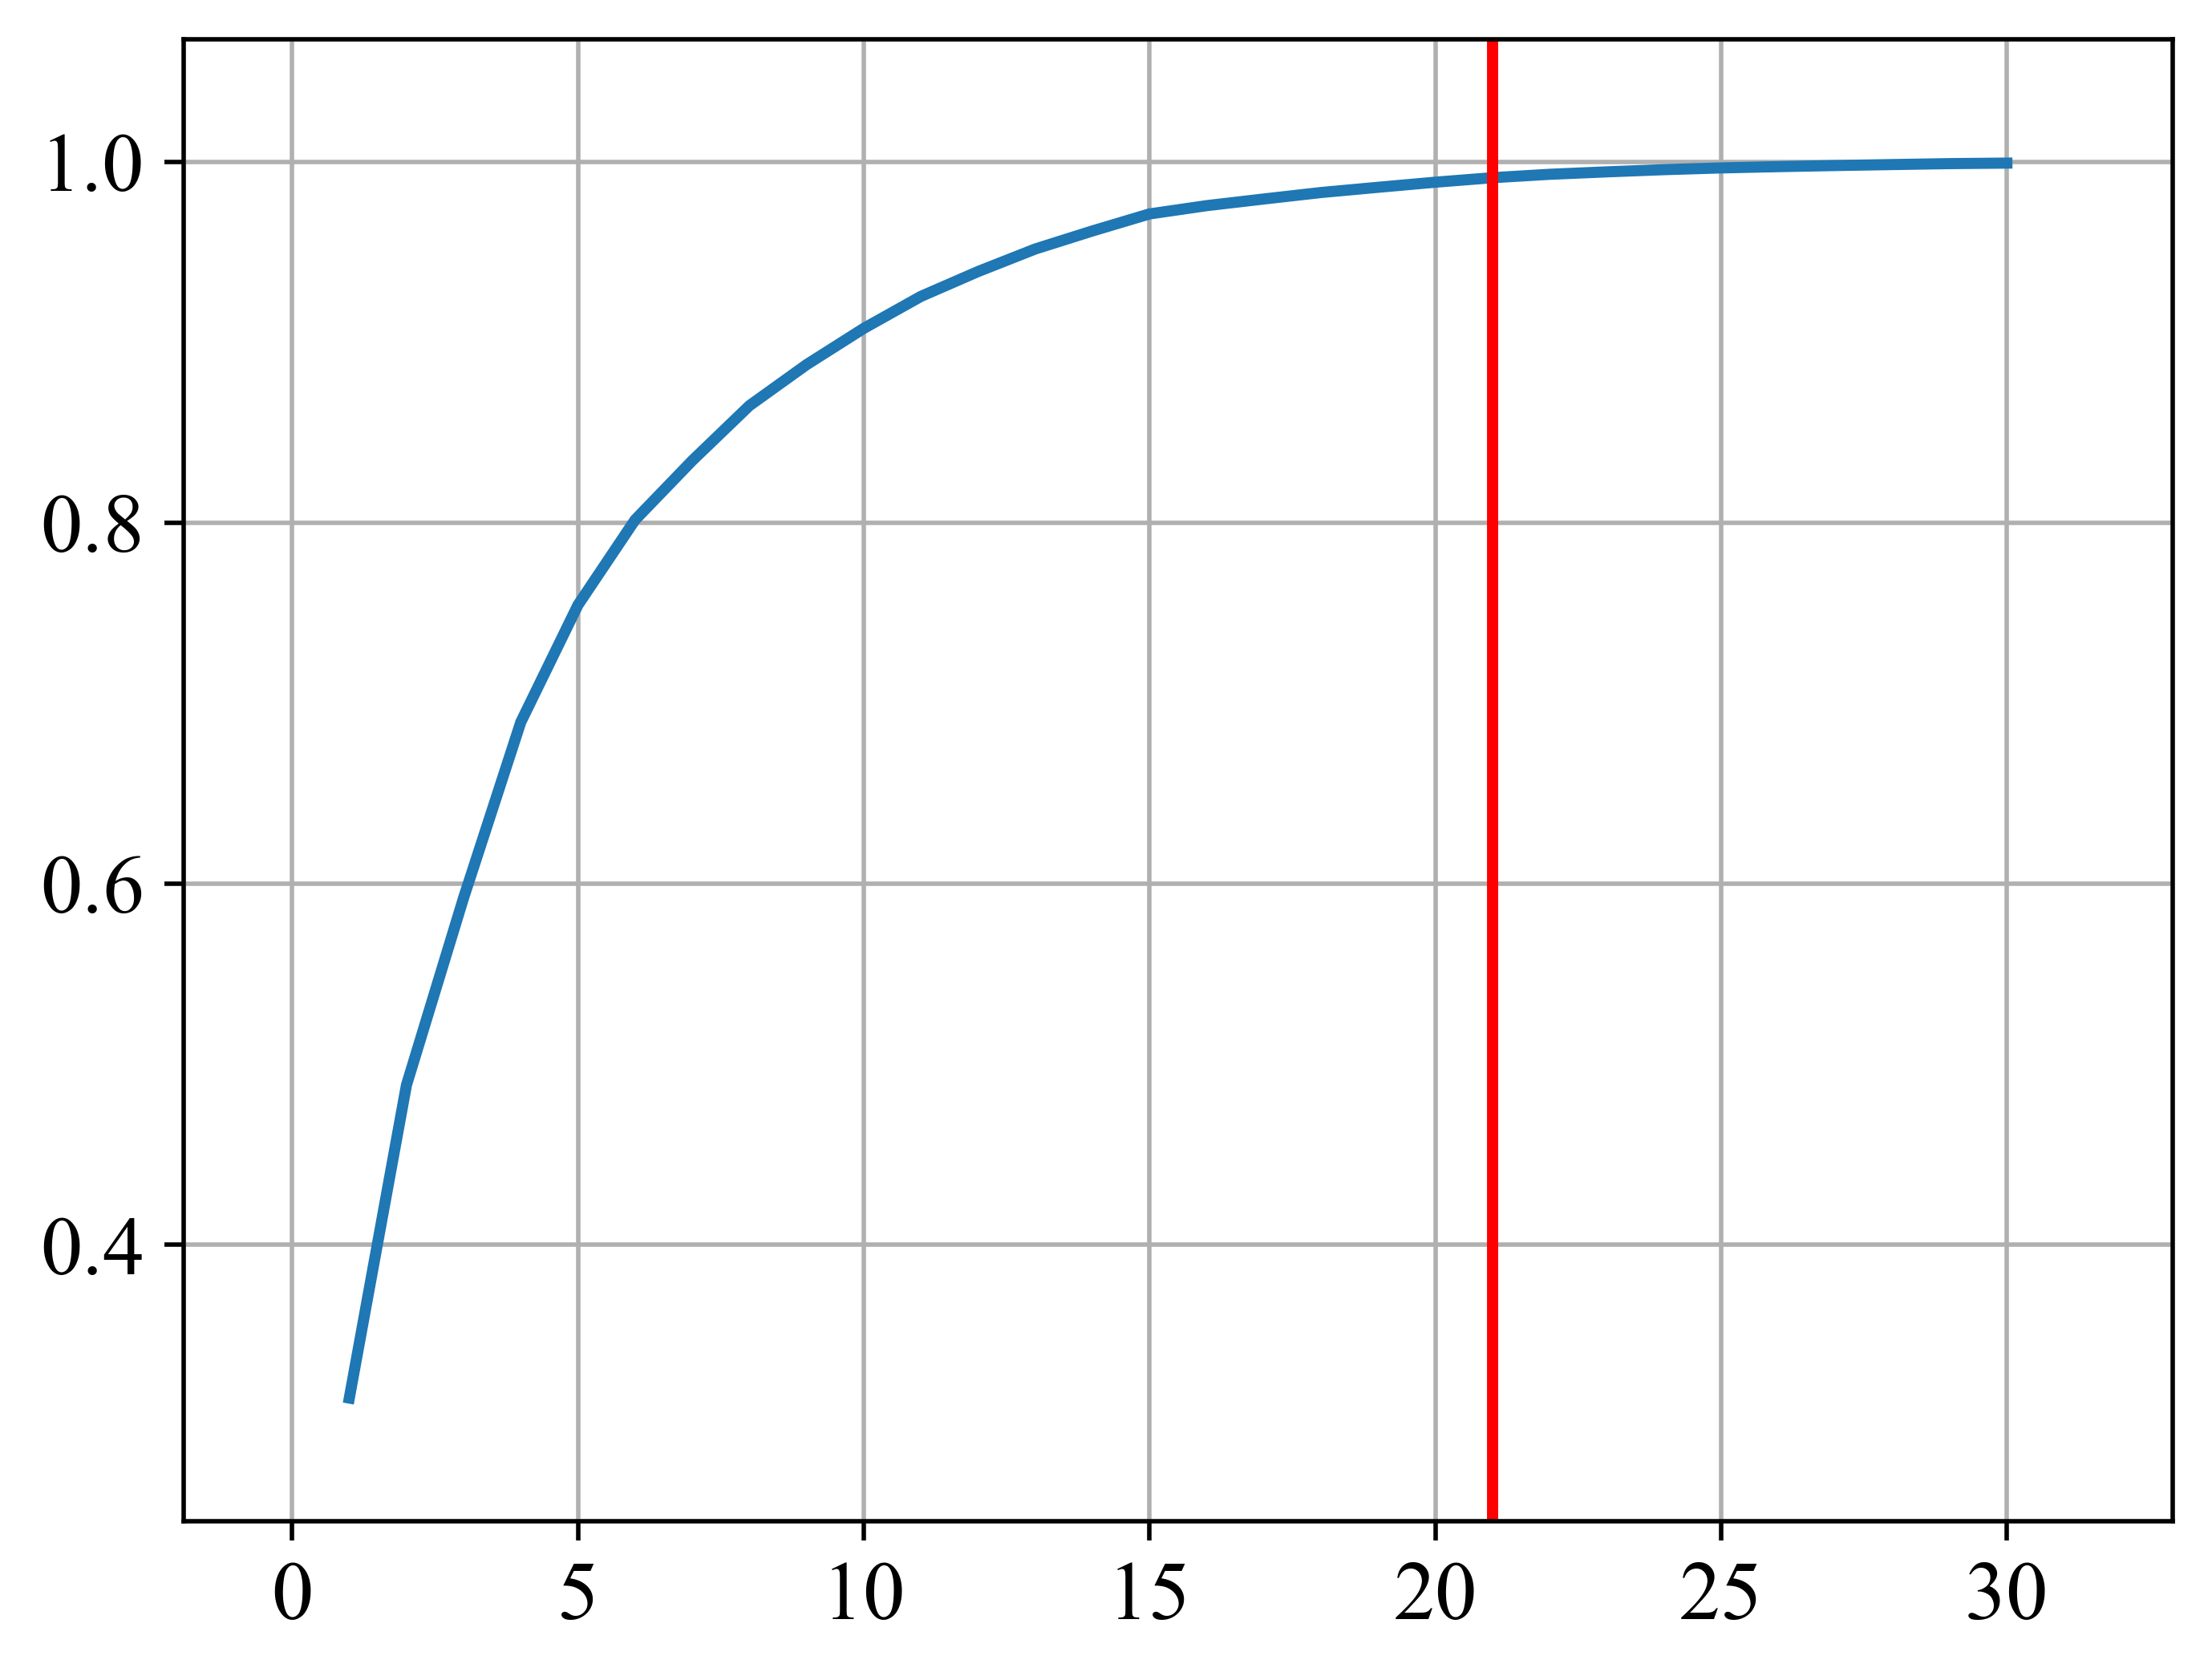

In [36]:
from sklearn.decomposition import PCA

evar = []
x = range(1, 31)
n_ = 0
for n in x:
    pca = PCA(n_components=n) # 주성분을 몇개로 할지 결정
    Xpca = pca.fit_transform(train_X)
    #print(Xpca.shape)
    #print(pca.explained_variance_ratio_)
    evar.append(sum(pca.explained_variance_ratio_))
    if n_ == 0 and sum(pca.explained_variance_ratio_) > 0.99 :
        n_ = n
plt.plot(x, evar)
plt.axvline(n_)
plt.show()

In [55]:
pca = PCA(n_components=13) 
Xpca_train = pca.fit_transform(train_X)
Xpca_test = pca.fit_transform(test_X)

## gaussian kde

In [56]:
from scipy.stats import gaussian_kde, entropy

In [57]:
train_kde = gaussian_kde(Xpca_train.T)
test_kde = gaussian_kde(Xpca_test.T)

In [58]:
np.concatenate([train_X, test_X]).shape

(946716, 51)

In [59]:
Xm = np.concatenate([Xpca_train, Xpca_test]).min(axis=0)
XM = np.concatenate([Xpca_train, Xpca_test]).max(axis=0)

In [63]:
grid = np.linspace(Xm, XM, 100).T

In [64]:
grid.shape

(13, 100)

In [65]:
entropy(train_kde(grid), test_kde(grid))

105.66848097653478

In [18]:

#gaussian_kde(train_X[:, c])

xmin = train_X[:, c].min()
xmax = train_X[:, c].max()

grid = np.linspace(xmin, xmax, 100)
grid

array([-4.01381445, -3.95491649, -3.89601853, -3.83712058, -3.77822262,
       -3.71932466, -3.6604267 , -3.60152875, -3.54263079, -3.48373283,
       -3.42483487, -3.36593692, -3.30703896, -3.248141  , -3.18924304,
       -3.13034508, -3.07144713, -3.01254917, -2.95365121, -2.89475325,
       -2.8358553 , -2.77695734, -2.71805938, -2.65916142, -2.60026347,
       -2.54136551, -2.48246755, -2.42356959, -2.36467163, -2.30577368,
       -2.24687572, -2.18797776, -2.1290798 , -2.07018185, -2.01128389,
       -1.95238593, -1.89348797, -1.83459002, -1.77569206, -1.7167941 ,
       -1.65789614, -1.59899819, -1.54010023, -1.48120227, -1.42230431,
       -1.36340635, -1.3045084 , -1.24561044, -1.18671248, -1.12781452,
       -1.06891657, -1.01001861, -0.95112065, -0.89222269, -0.83332474,
       -0.77442678, -0.71552882, -0.65663086, -0.59773291, -0.53883495,
       -0.47993699, -0.42103903, -0.36214107, -0.30324312, -0.24434516,
       -0.1854472 , -0.12654924, -0.06765129, -0.00875333,  0.05

In [19]:
kernel = gaussian_kde(train_X[:, c])

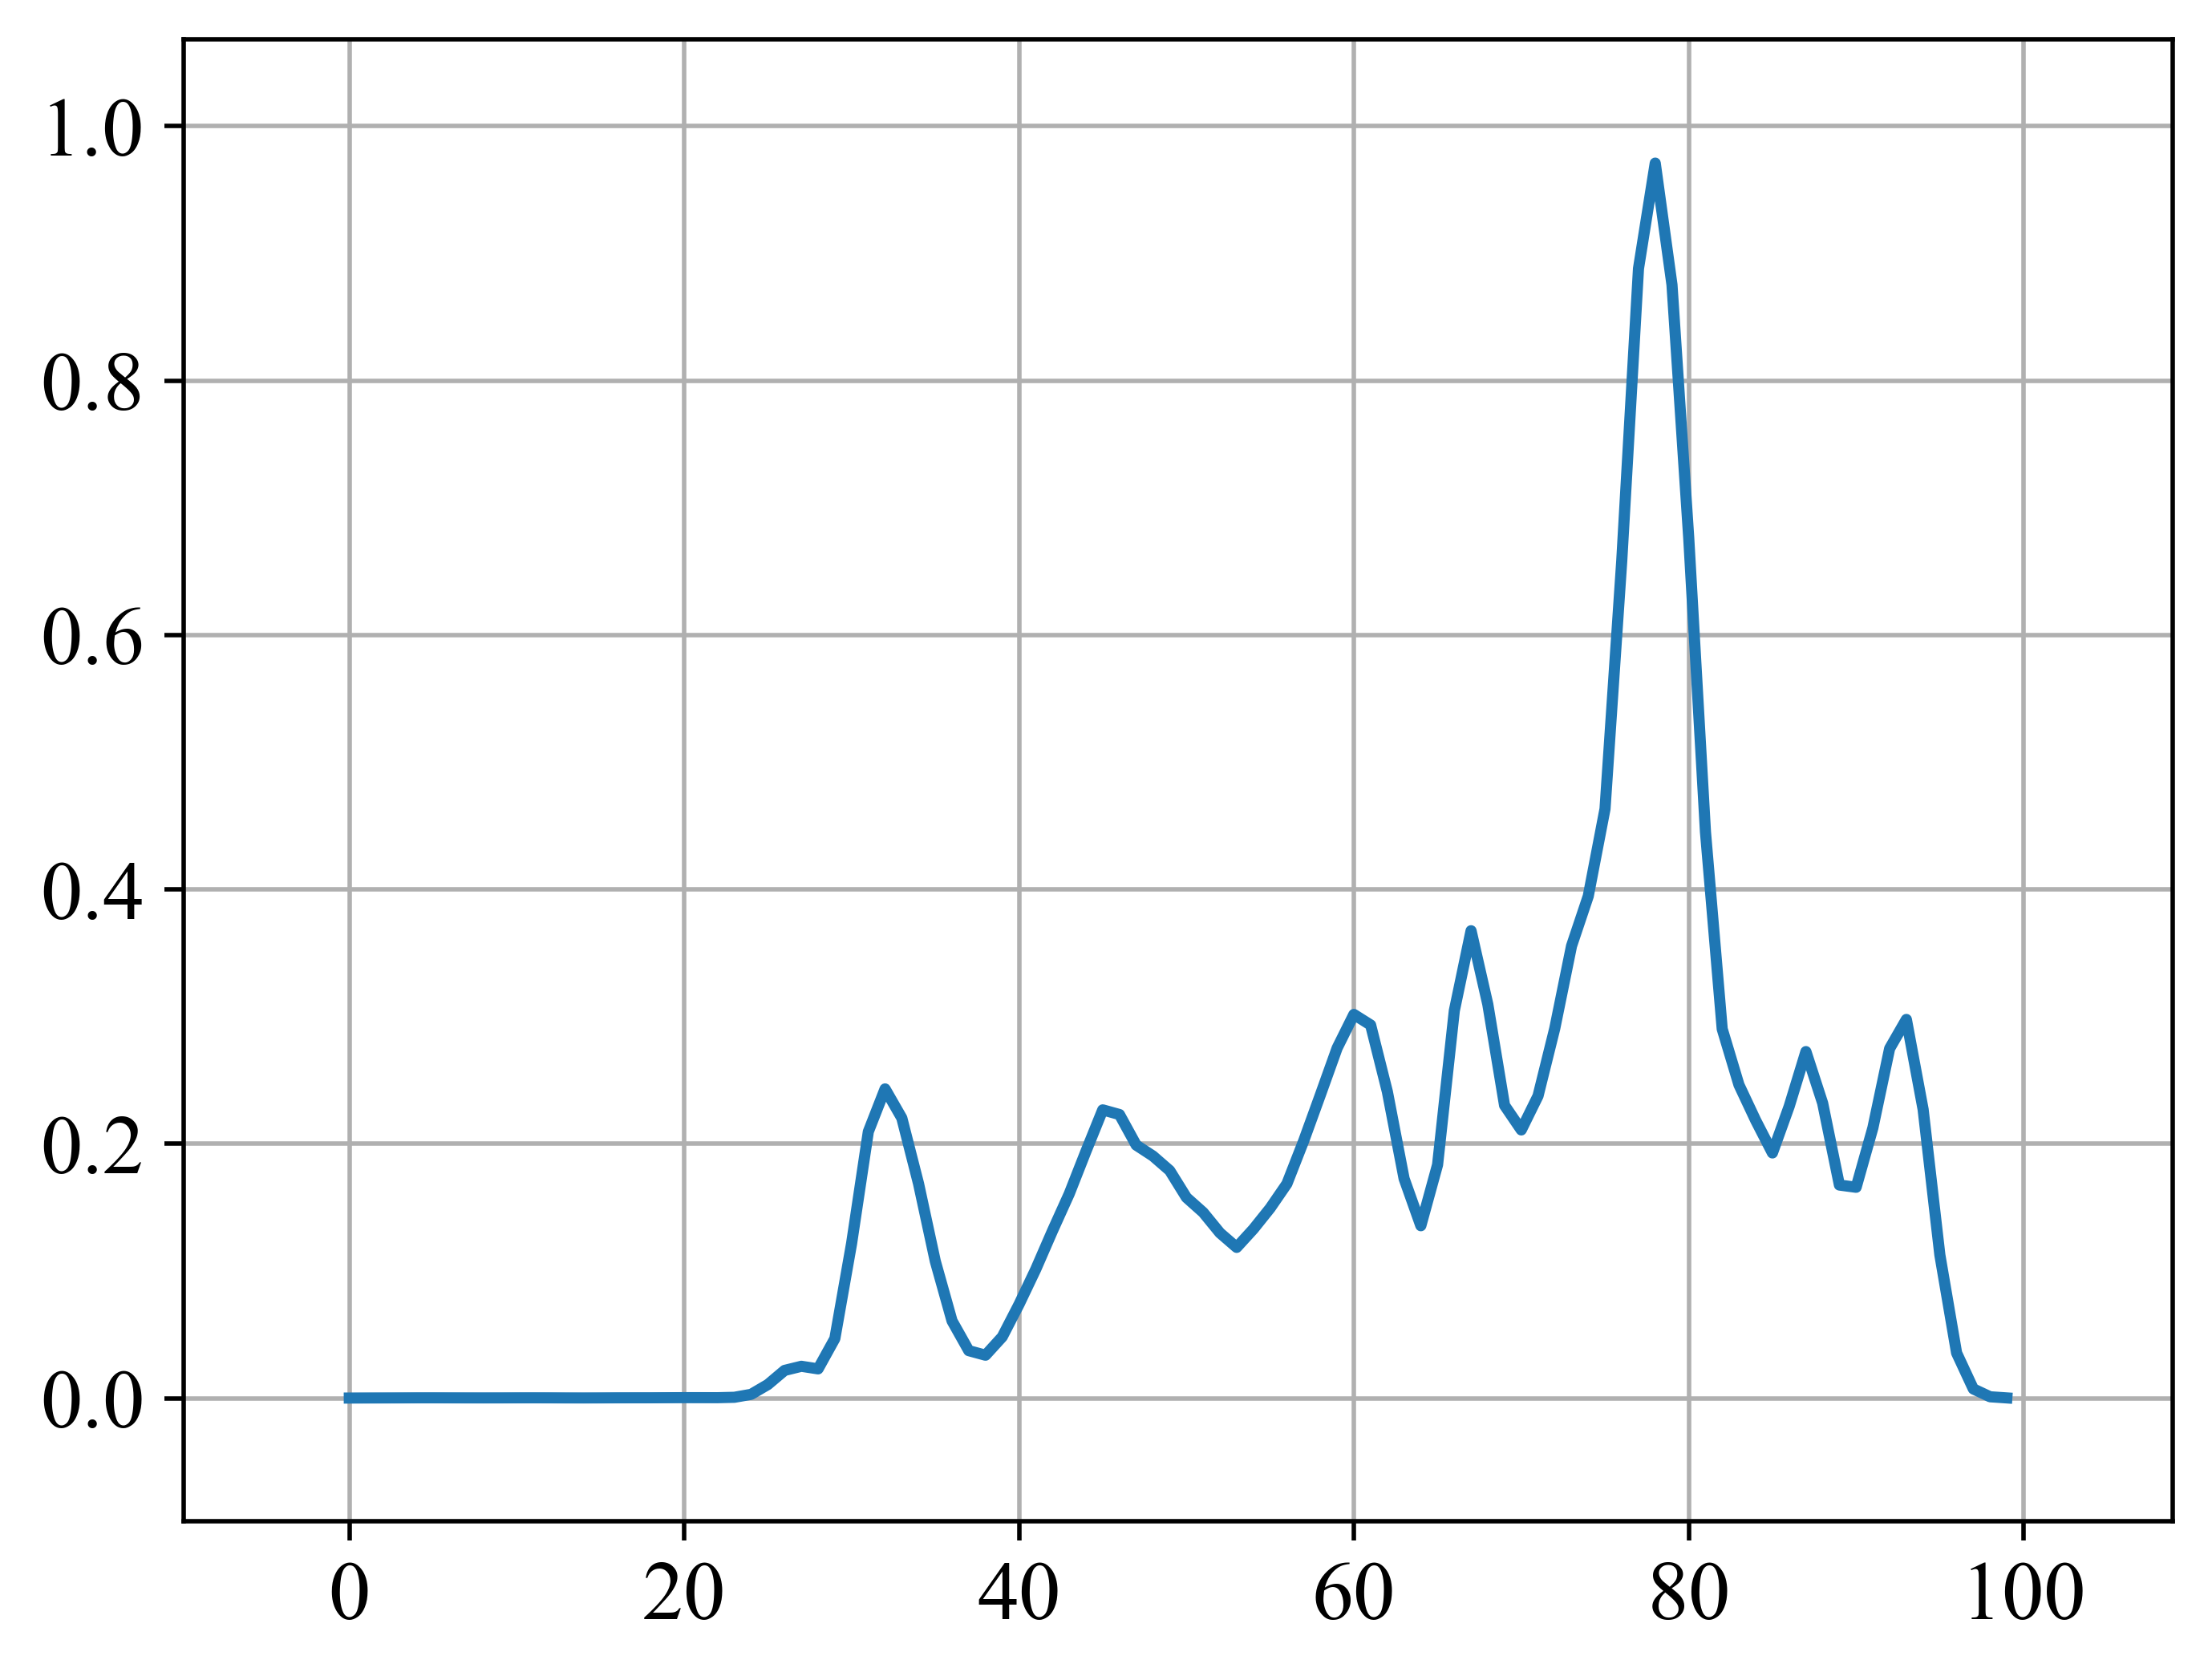

In [21]:
plt.plot(kernel(grid))

In [9]:
from sklearn.neighbors import KernelDensity
kde_emp = KernelDensity(bandwidth=5e-5)
emp_values = np.array([0.000618, 0.000425, 0.000597, 0.000528, 0.000393, 0.000721,
   0.000674, 0.000703, 0.000632, 0.000383, 0.000466, 0.000919,
   0.001419, 0.00063 , 0.000433, 0.000516, 0.001419, 0.000655,
   0.000674, 0.000676, 0.000694, 0.000396, 0.000688, 0.00061 ,
   0.000687, 0.000633, 0.000601, 0.00061 , 0.000747, 0.000356,
   0.000824, 0.000931, 0.000691, 0.000907, 0.000553, 0.000748,
   0.000828, 0.000907, 0.000457, 0.000494])
kde_emp = KernelDensity().fit(emp_values.reshape(-1, 1))

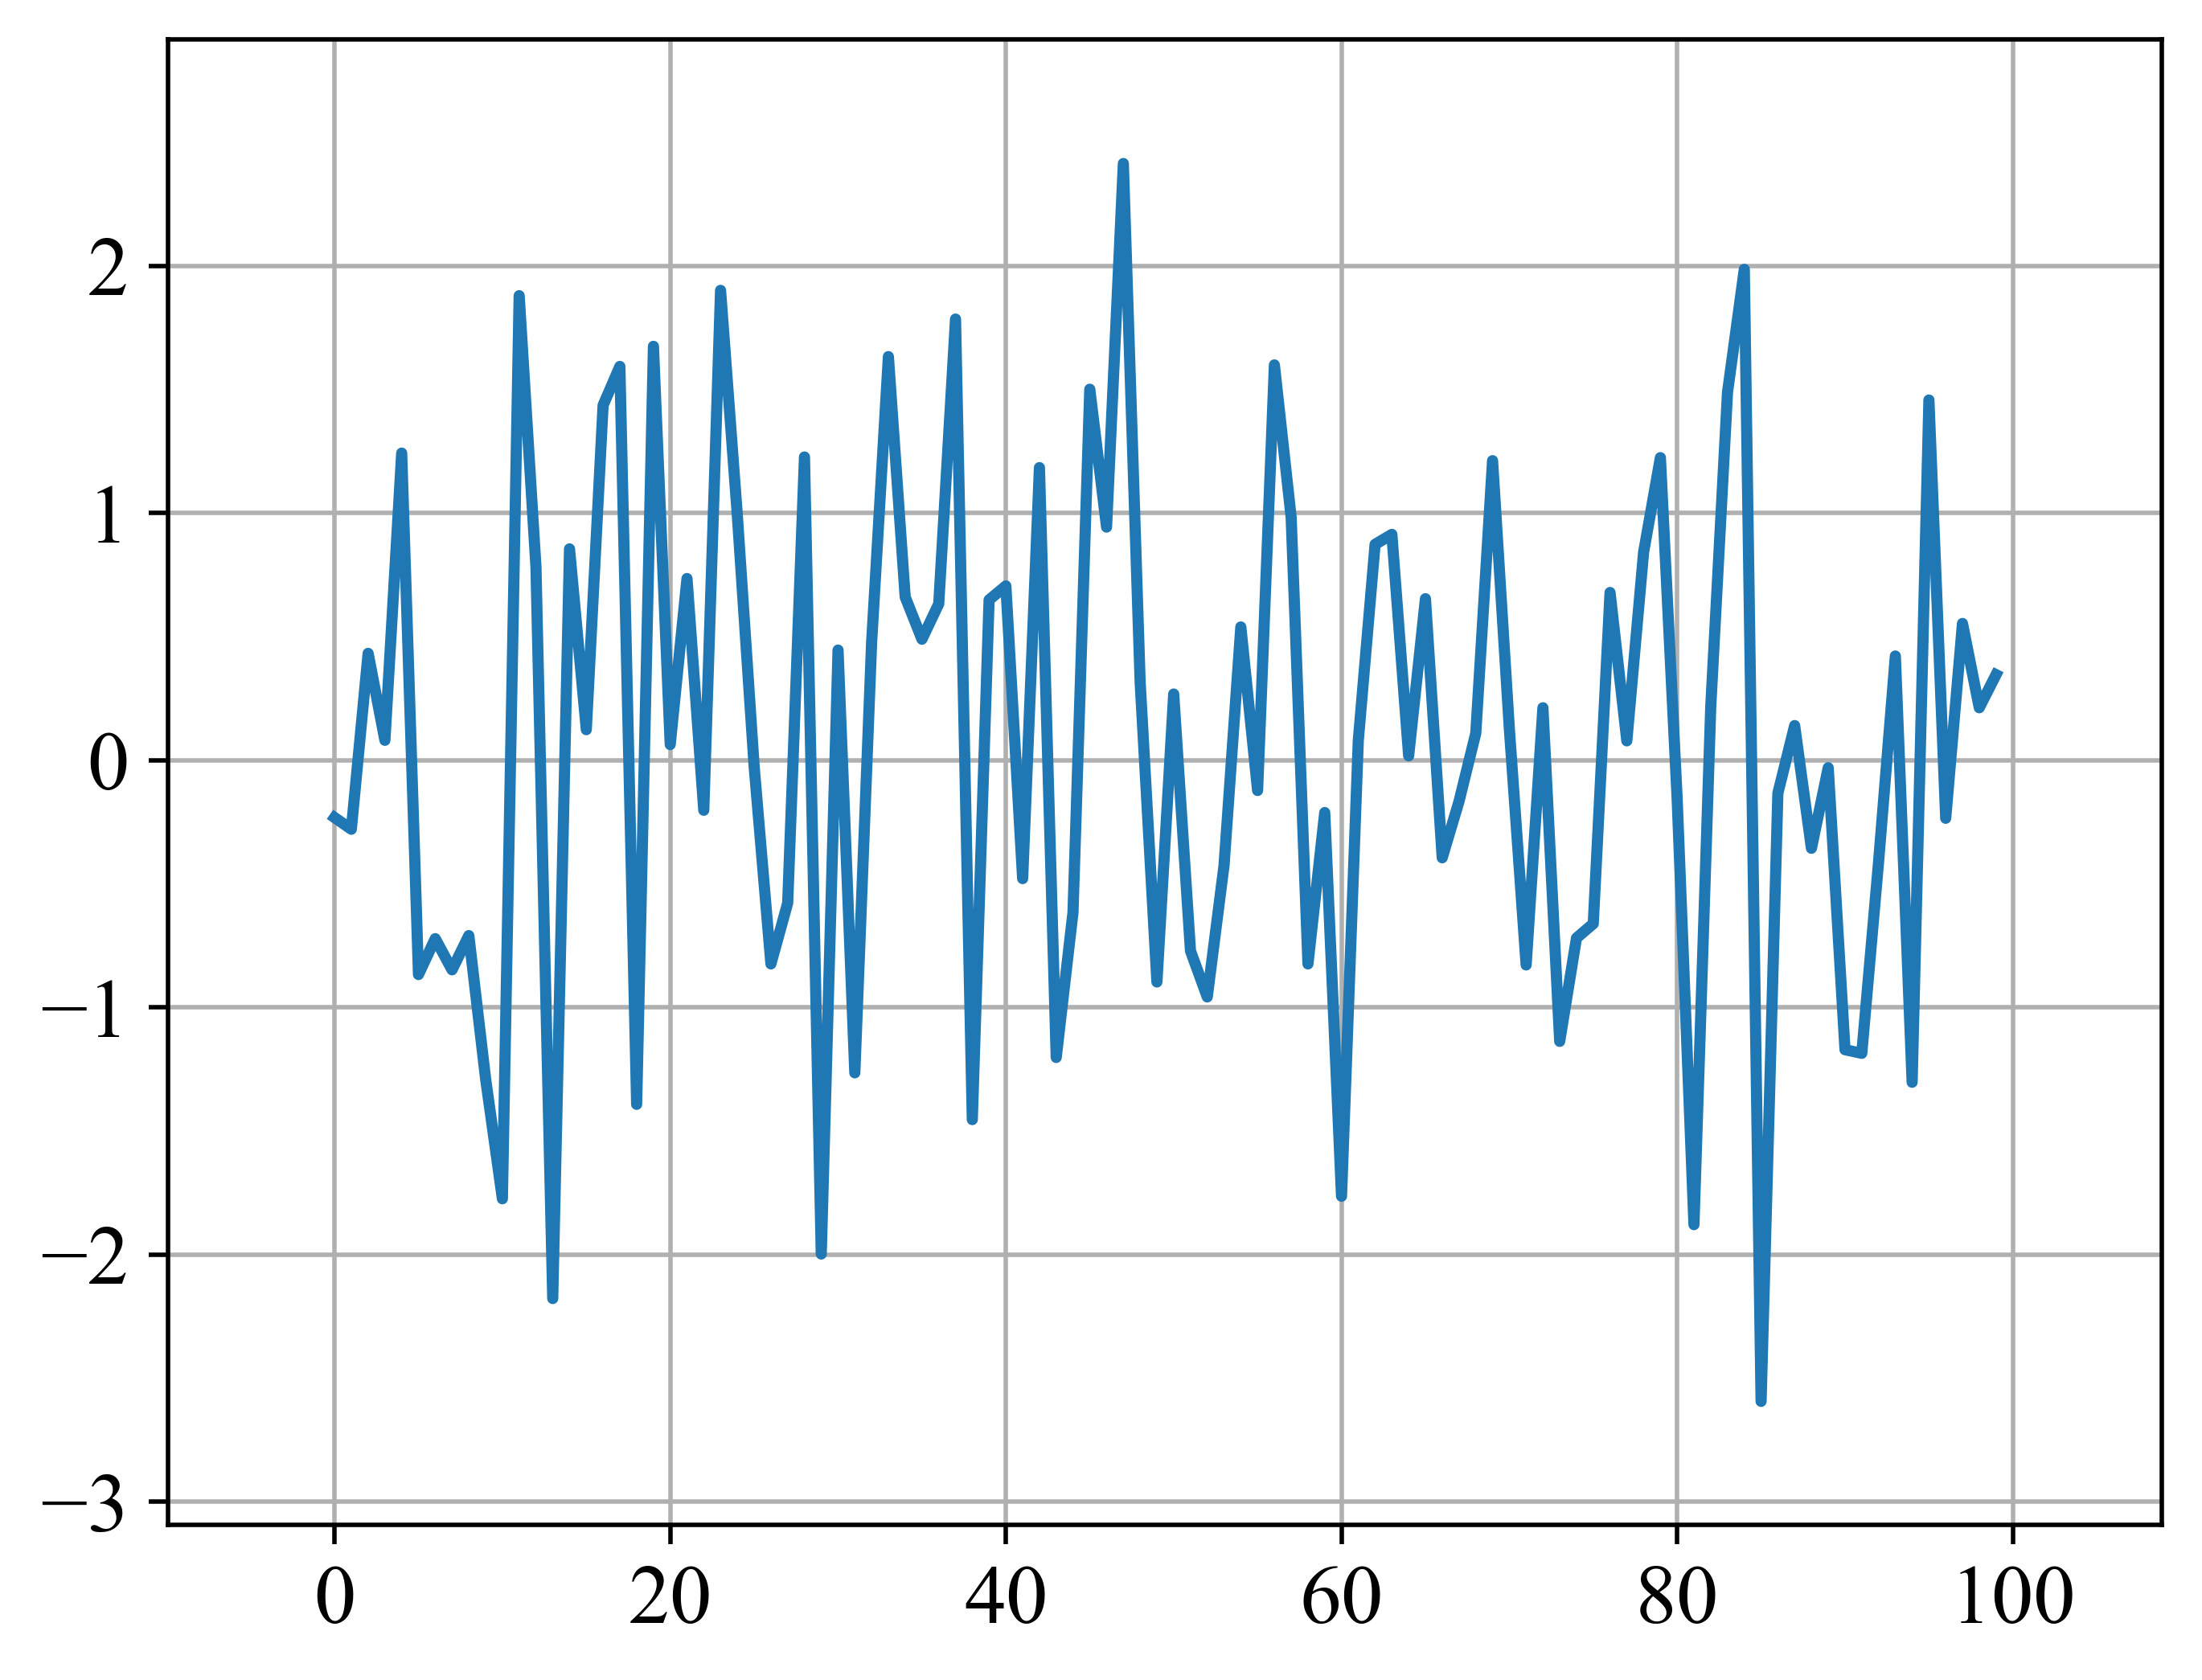

In [16]:
plt.plot(kde_emp.sample(100))

In [13]:

kde_emp(np.arange(-10, 0, 0.01))

TypeError: 'KernelDensity' object is not callable

In [ ]:
from sklearn.neighbors import KernelDensity
kde_emp = KernelDensity(bandwidth=5e-5)
kde_emp.fit(emp_values.reshape(-1, 1))